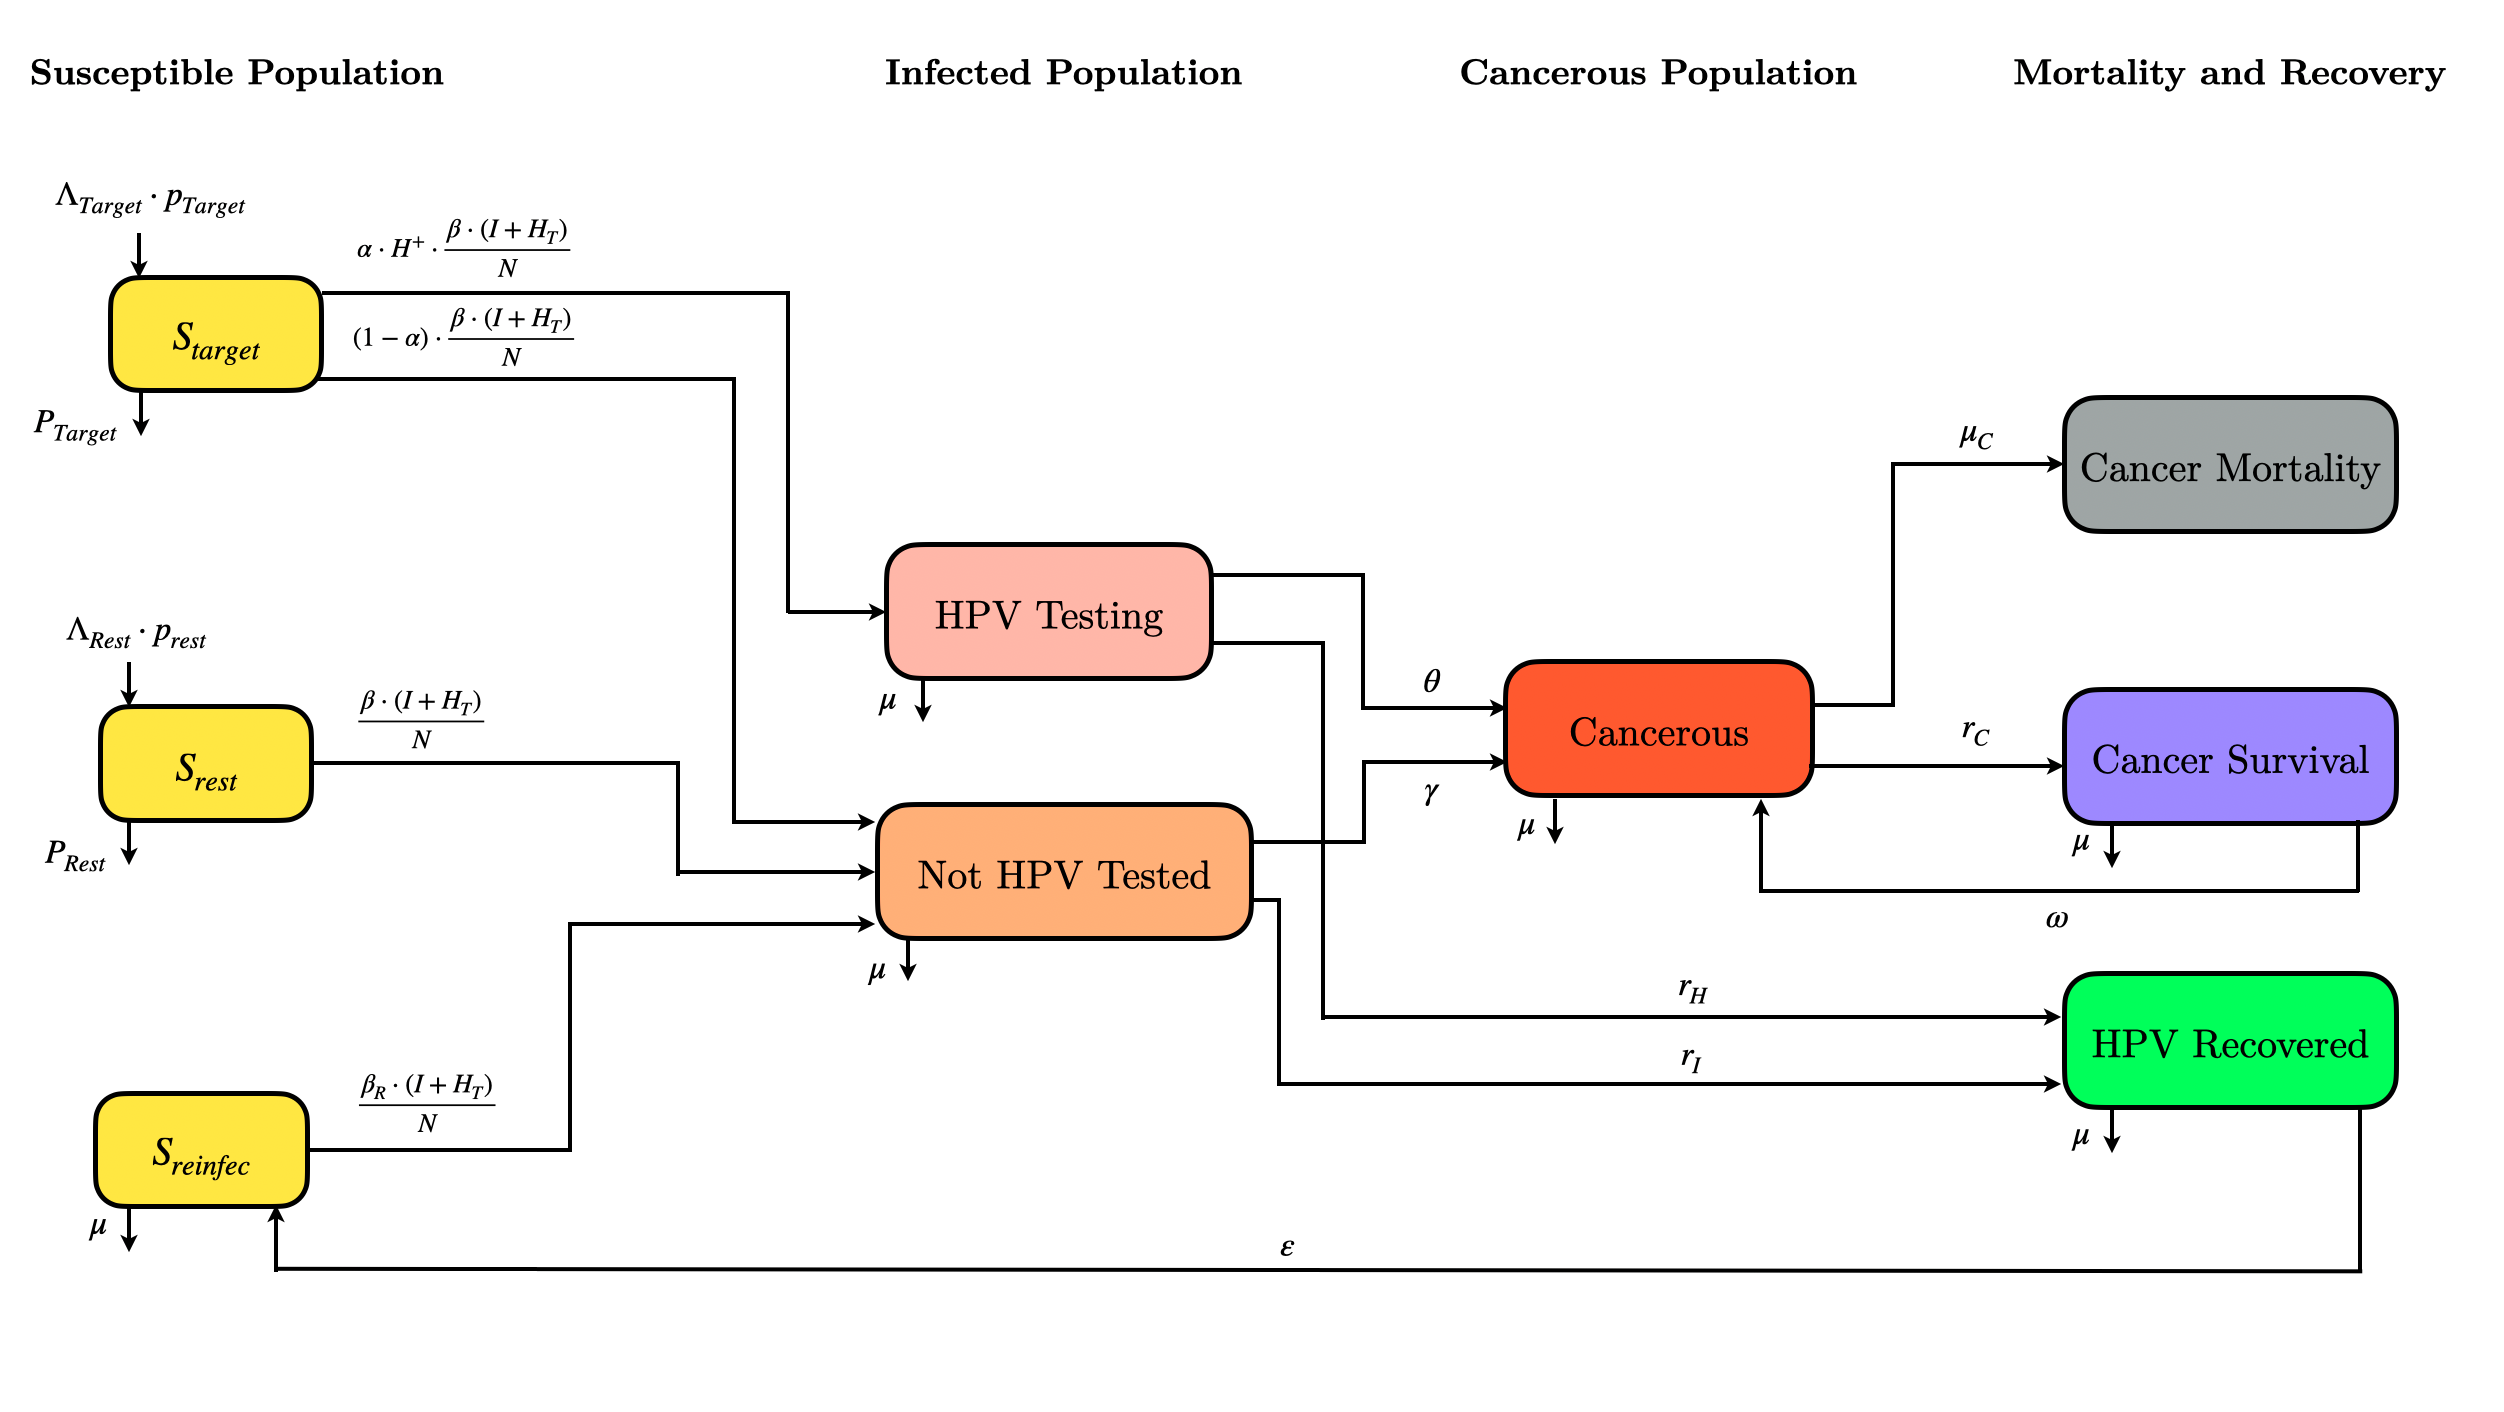

#### Susceptible Population

$$
\frac{dS_{Target}}{dt} = \Lambda_{Target}(t) \cdot p_{Target} - \left( \alpha \cdot H^+ \cdot \frac{\beta \cdot (I + H_T)}{N} + (1 - \alpha) \cdot \frac{\beta \cdot (I + H_T)}{N} + P_{Target} \right) S_{Target}
$$

$$
\frac{dS_{Rest}}{dt} = \Lambda_{Rest}(t) \cdot p_{Rest} - \left( \frac{\beta \cdot (I + H_T)}{N} + P_{Rest} \right) S
$$

$$
\frac{dS_R}{dt} =  \varepsilon \cdot R_H - \left(\frac{\beta_R \cdot (I + H_T)}{N} + \mu \right) S_R
$$


#### Infected Population

$$
\frac{dH_T}{dt} =  \alpha \cdot H^+ \cdot \frac{\beta \cdot (I + H_T)}{N} \cdot S_{Target} - (\theta + r_H + \mu) H_T
$$


$$
\frac{dI}{dt} = (1 - \alpha) \cdot \frac{\beta \cdot (I + H_T)}{N} \cdot S_{Target} +  \frac{\beta \cdot (I + H_T)}{N} \cdot S_{Rest} +  \frac{\beta_R \cdot (I + H_T)}{N} \cdot S_R - (\gamma + r_I + \mu) I
$$

#### Cancerous Population

$$
\frac{dC}{dt} = \theta \cdot H_S + \gamma \cdot I + \omega \cdot C_S - (r_C + \mu + \mu_C) \cdot C
$$



#### Mortality and Recovered

$$
\frac{dR_H}{dt} = r_H \cdot H_S + r_I \cdot I - \left[\varepsilon + \mu\right] \cdot R_H
$$

$$
\frac{dC_S}{dt} = r_C \cdot C - (\omega + \mu) \cdot C_S
$$

$$
\frac{dC_D}{dt} = \mu_C \cdot C
$$

## Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import matplotlib.collections as mcoll
import matplotlib.gridspec as gridspec

import os
import sys
sys.path.append( '/Users/arvinth/Documents/Nirav Bhat DDP/Professional Plots')
import publish

#default look & feel for every plot that follows
plt.rcParams.update({
    'lines.linewidth' : 2,        # thicker curves
    'axes.grid'       : True,     # turn grid on
    'axes.grid.which' : 'both',
    'grid.color'      : 'lightgray',
    'grid.alpha'      : 1.0,
    'axes.titlesize'  : 20,       # subplot titles
    'axes.labelsize'  : 18,       # axis labels
    'xtick.labelsize' : 14,
    'ytick.labelsize' : 14,
    'legend.fontsize' : 14
})

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'

## Initialization and Complete Simulation

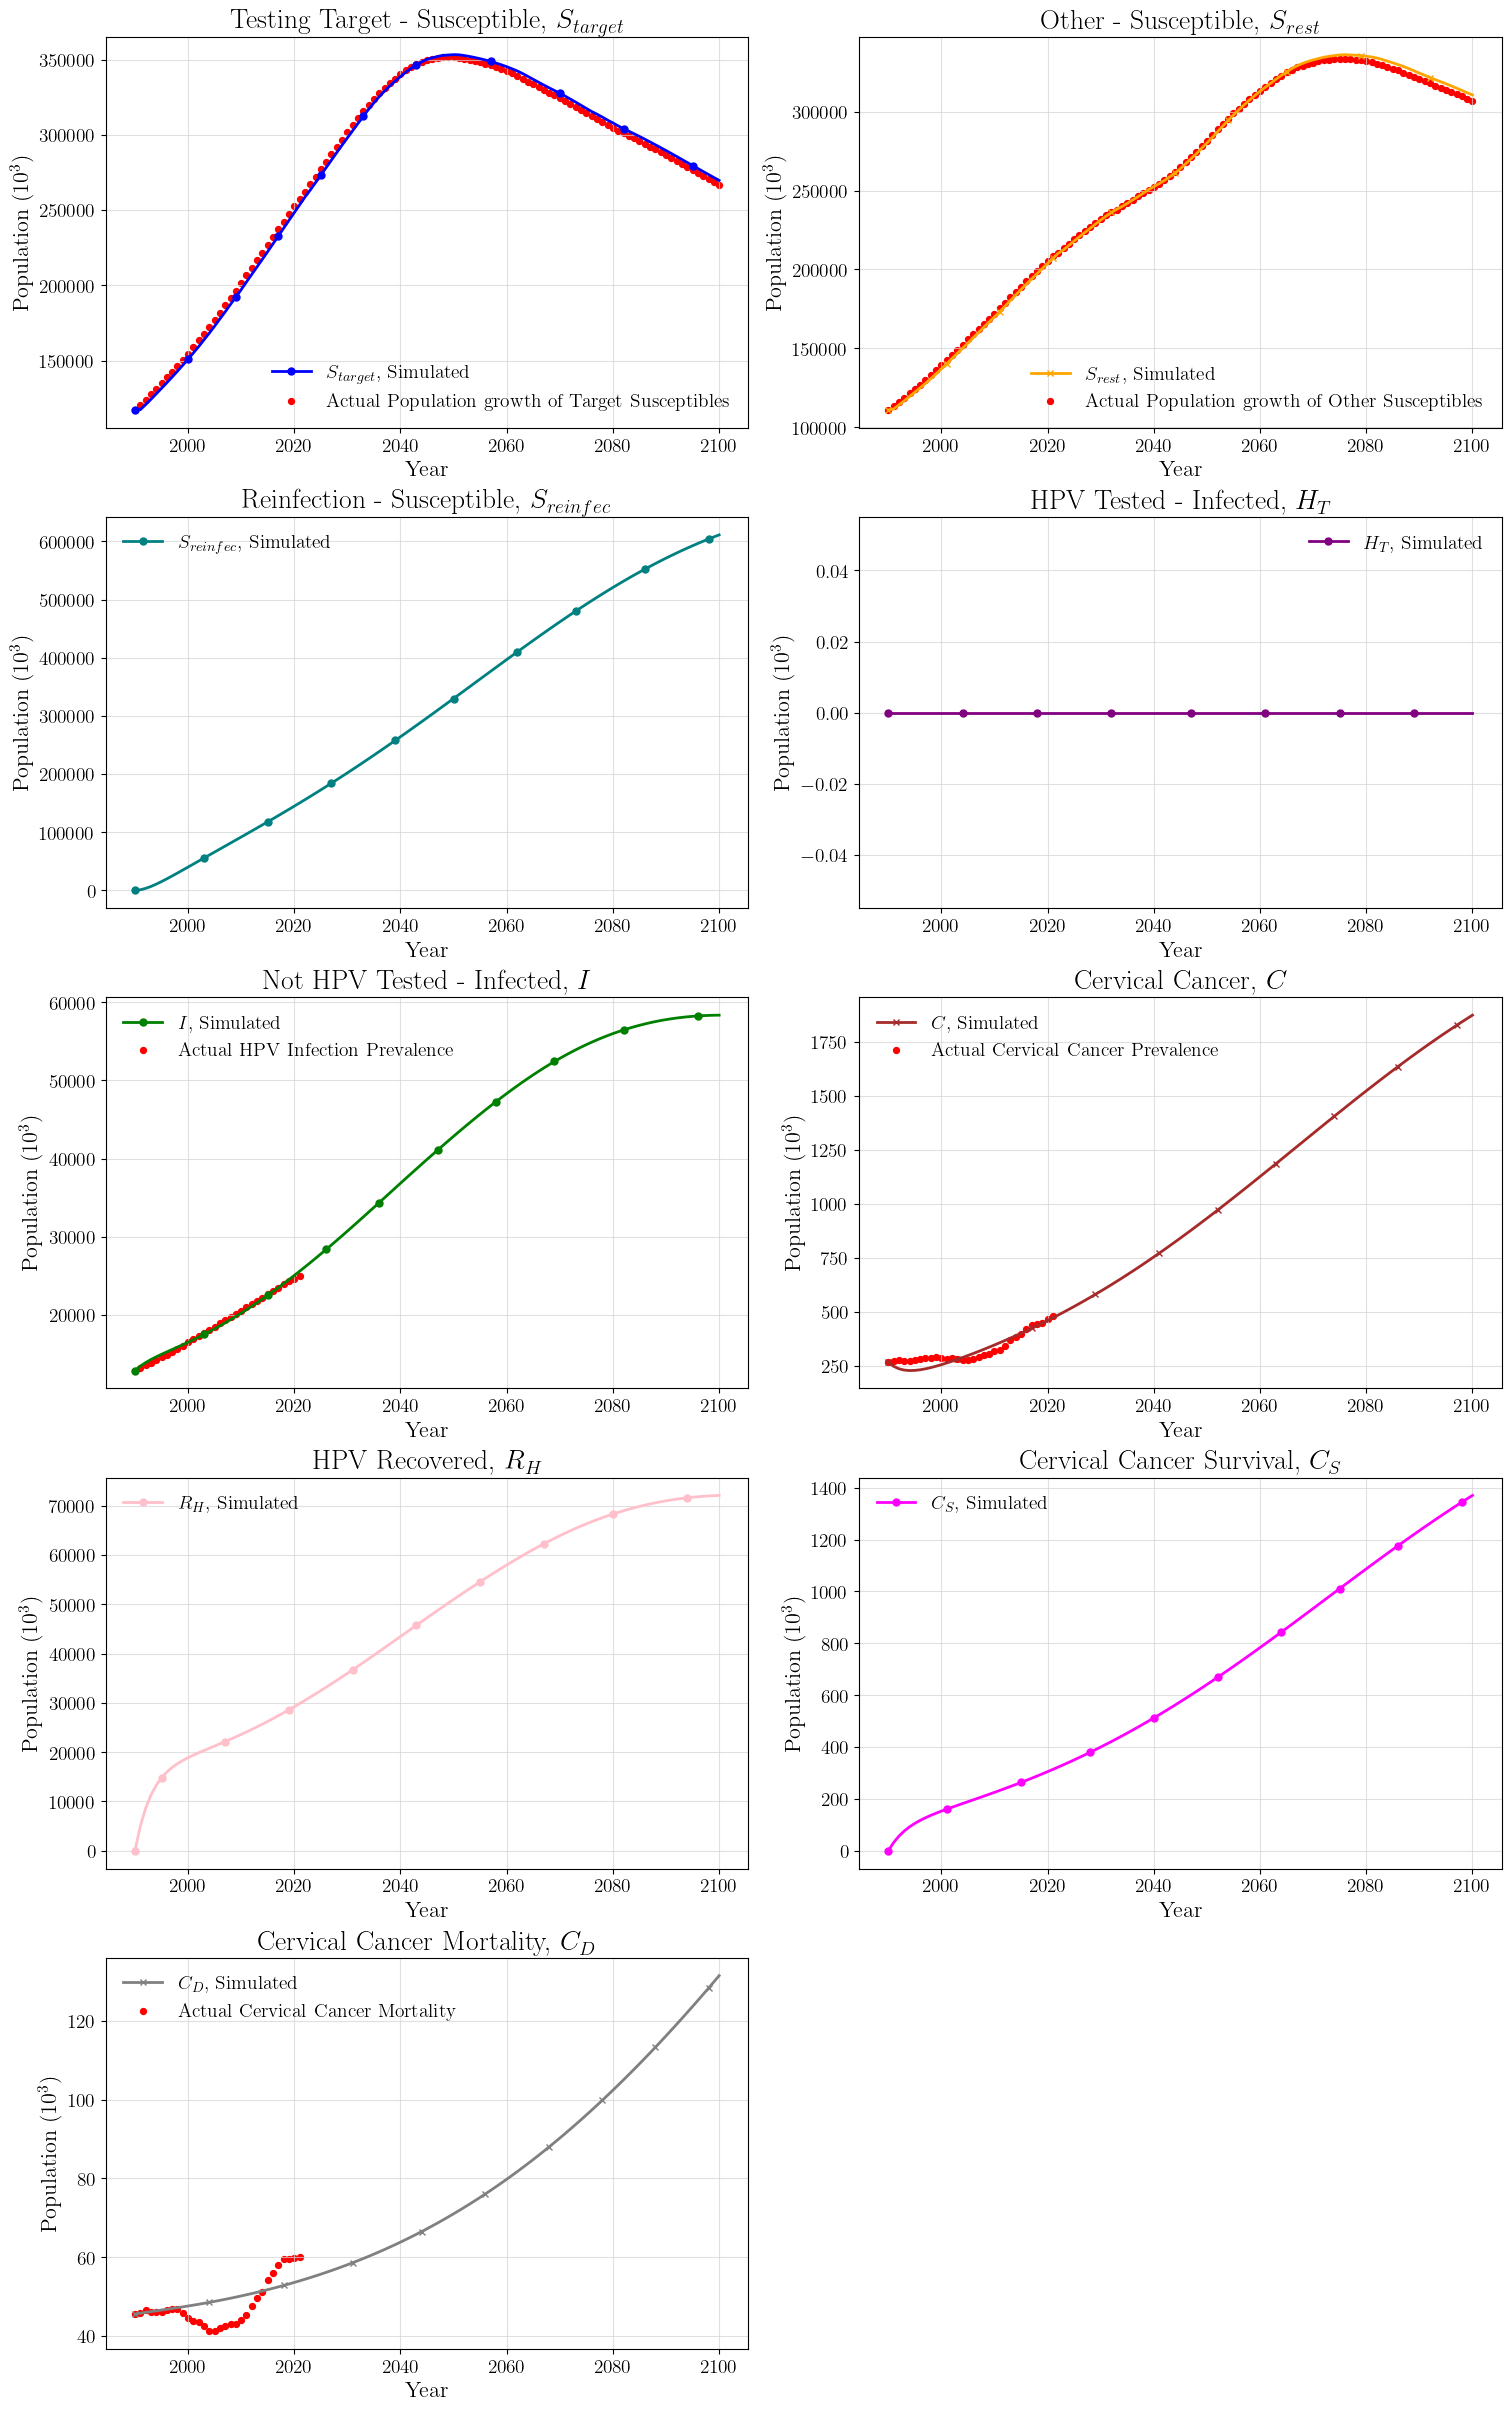

In [44]:
TOTAL_LO, TOTAL_HI   = 18, 85     # overall female span [inclusive]
TARGET_LO, TARGET_HI = 30, 60     # screening-target band
SCR_START_TGT        = 2020       # α  kicks in
SCR_START_REINF      = 2000       # α_R kicks in

CSV_POP    = ("/Users/arvinth/Documents/Nirav Bhat DDP/DDP/Vaccination+Screening/"
              "WHO Data/CSV Files/Population/India_timeseries/India_Population_TimeSeries_Female.csv")
CSV_LAMBDA = ("/Users/arvinth/Documents/Nirav Bhat DDP/DDP/Vaccination+Screening/"
              "Generated Data/Extended_Lambda_0_to_99.csv")            # needs “Time” column
CSV_PARAM  = ("/Users/arvinth/Documents/Nirav Bhat DDP/DDP/Vaccination+Screening/"
              "Inittial Codes/fitted_params.csv")

START_YEAR, END_YEAR = 1990, 2100
years = np.arange(START_YEAR, END_YEAR + 1)


ages       = np.arange(TOTAL_LO, TOTAL_HI + 1)
idx_target = [a for a in ages if TARGET_LO <= a <= TARGET_HI]
idx_rest   = [a for a in ages if a not in idx_target]

def sum_cols(row, cols): return row[cols].sum()

# population by age
df_pop = pd.read_csv(CSV_POP); df_pop = df_pop[df_pop["Time"] <= END_YEAR]
pop_T = {yr: sum_cols(r, [f"Age{a}" for a in idx_target])
         for yr, r in df_pop.set_index("Time").iterrows()}
pop_R = {yr: sum_cols(r, [f"Age{a}" for a in idx_rest])
         for yr, r in df_pop.set_index("Time").iterrows()}

# annual inflow λ by age
df_λ = pd.read_csv(CSV_LAMBDA)
if "Year" in df_λ.columns: df_λ.rename(columns={"Year":"Time"}, inplace=True)
lam_T = {yr: sum_cols(r, [f"Age{a}" for a in idx_target])
         for yr,r in df_λ.set_index("Time").iterrows()}
lam_R = {yr: sum_cols(r, [f"Age{a}" for a in idx_rest ])
         for yr,r in df_λ.set_index("Time").iterrows()}
λ_min, λ_max = df_λ["Time"].min(), df_λ["Time"].max()
Λ_T = lambda t: lam_T[int(np.clip(np.floor(t), λ_min, λ_max))]
Λ_R = lambda t: lam_R[int(np.clip(np.floor(t), λ_min, λ_max))]

# small-p and big-P per age
df_p = pd.read_csv(CSV_PARAM).sort_values("Age", ignore_index=True)
p, P = df_p["p"].values, df_p["P"].values
p_T, p_R = p[idx_target].sum(), p[idx_rest].sum()
P_T, P_R = P[idx_target].sum(), P[idx_rest].sum()

# observed series
S_T_obs = np.array([pop_T[yr] for yr in years])
S_R_obs = np.array([pop_R[yr] for yr in years])
I_obs = np.array([
    12835.316, 13162.292, 13494.572, 13832.780, 14174.004, 14525.316,
    14890.460, 15264.132, 15646.124, 16036.488, 16432.780, 16837.444,
    17240.756, 17640.220, 18049.668, 18457.504, 18864.820, 19271.668,
    19670.716, 20079.696, 20502.352, 20926.724, 21349.224, 21772.088,
    22193.756, 22610.848, 23034.024, 23459.540, 23869.196, 24253.632,
    24620.492, 24955.892])

C_obs   = np.array([
    267.570961 , 271.6169256, 275.7054515, 274.0737991, 274.9812207, 276.3872459,
    280.6243342, 285.1879923, 288.2231845, 289.5141671, 287.3038003, 284.7191063,
    284.9420885, 280.4508179, 275.6836137, 278.3185388, 284.3301878, 290.6745076,
    301.063372 , 307.7763671, 317.7215889, 323.9395645, 343.2665689, 371.1894989,
    382.1297507, 400.0806666, 419.8269115, 441.8209205, 445.0365926, 448.5126828,
    468.6937573, 480.6489059])
CD_obs  = np.array([
    45.55142946, 45.91195481, 46.53156496, 46.03818121, 46.09763001, 46.17792166,
    46.57345157, 46.91001022, 46.92484298, 45.73139061, 44.48136413, 43.79001326,
    43.48650233, 42.60130859, 41.27663252, 41.24002807, 41.96599955, 42.48392263,
    43.12009193, 42.99204395, 43.94447957, 45.22039566, 47.55677589, 49.71378642,
    51.23429407, 54.11848041, 55.96605026, 58.13566003, 59.47900721, 59.61843941,
    59.77279921, 60.04082304])


def α(t):   return 0.0 if t < SCR_START_TGT  else 0.0   # target coverage
def α_R(t): return 0.0 if t < SCR_START_REINF else 0.00 # reinf-screen coverage

par = dict(
    H_pos  = 1.0,
    beta   = 0.543262,
    beta_R = 0.4932,
    mu     = 0.01388,
    gamma  = 0.00128338,
    theta  = 0.00128338/10,
    r_H    = 0.90,
    r_I    = 0.45,
    r_C    = 0.67/5,
    epsilon= 0.35,
    mu_C   = 0.000852595,
    omega  = 0.16
)

# Best-fit values (ω fixed at 0.16)
# beta   = 0.543262
# beta_R = 0.4932
# gamma  = 0.00128338
# mu_C   = 0.000852595
# omega  = 0.16


def model(state, t, p):
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = state
    N = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T  = p['beta']   * (I + H_T) / N
    i_RE = p['beta_R'] * (I + H_T) / N

    dS_T   = Λ_T(t)*p_T - ((α(t)*p['H_pos'] + 1-α(t)) * λ_T + P_T) * S_T
    dS_Rst = Λ_R(t)*p_R - (λ_T + P_R) * S_Rest
    dS_R   = p['epsilon']*R_H - ((α_R(t)*p['H_pos'] + 1-α_R(t)) * i_RE + p['mu']) * S_R

    infl_HT = α(t)*p['H_pos']*λ_T*S_T + α_R(t)*p['H_pos']*i_RE*S_R
    infl_I  = (1-α(t))*λ_T*S_T + λ_T*S_Rest + (1-α_R(t))*i_RE*S_R

    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu']) * H_T
    dI   = infl_I  - (p['gamma'] + p['r_I'] + p['mu']) * I

    dC   = p['theta']*H_T + p['gamma']*I + p['omega']*C_S - (p['r_C'] + p['mu'] + p['mu_C']) * C
    dR_H = p['r_H']*H_T + p['r_I']*I - (p['epsilon'] + p['mu']) * R_H
    dC_S = p['r_C']*C - (p['omega'] + p['mu']) * C_S
    dC_D = p['mu_C']*C
    return [dS_T, dS_Rst, dS_R, dH_T, dI, dC, dR_H, dC_S, dC_D]


y0 = [S_T_obs[0], S_R_obs[0], 0.0, 0.0, I_obs[0], C_obs[0], 0.0, 0.0, CD_obs[0]]
sol = odeint(model, y0, years, args=(par,))
S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = sol.T


# titles = [
#     r'Target - Susceptible,  $S_{target}$',
#     r'Rest - Susceptible, $S_{rest}$',  
#     r'Reinfection - Susceptible, $S_{reinfec}$',  
#     r'HPV Tested - Infected, $H_T$',  # HS
#     r'Not HPV Tested - Infected, $I$',  # I
#     r'Cervical Cancer, $C$',  # C
#     r'HPV Recovered, $R_H$',  # RH
#     r'Cervical Cancer Mortality, $C_D$',  # CD
#     r'Cervical Cancer Survival, $C_S$'  # CR
# ]

fig, axs = plt.subplots(5, 2, figsize=(15, 24), constrained_layout=True); axs = axs.flatten()

def line(ax, y, lab, col, m):
    ax.plot(years, y/1, label=lab, color=col, marker=m)

def scatter_obs(ax, y, lab):
    ax.scatter(years[:len(y)], y/1, s=18, color='red', label=lab)

fmt = dict(fs_t=20, fs_xy=16)

# 0 – STarget
line(axs[0], S_T, '$S_{target}$, Simulated', 'blue', 'o')
scatter_obs(axs[0], S_T_obs, 'Actual Population growth of Target Susceptibles')
axs[0].set_title('Testing Target - Susceptible,  $S_{target}$', fontsize=fmt['fs_t'])

# 1 – SRest
line(axs[1], S_Rest, '$S_{rest}$, Simulated', 'orange', 'x')
scatter_obs(axs[1], S_R_obs, 'Actual Population growth of Other Susceptibles')
axs[1].set_title('Other - Susceptible, $S_{rest}$', fontsize=fmt['fs_t'])

# 2 – SR
line(axs[2], S_R, '$S_{reinfec}$, Simulated', 'teal', 'o'); axs[2].set_title('Reinfection - Susceptible, $S_{reinfec}$', fontsize=fmt['fs_t'])

# 3 – HT
line(axs[3], H_T, '$H_T$, Simulated', 'purple', 'o'); axs[3].set_title('HPV Tested - Infected, $H_T$', fontsize=fmt['fs_t'])

# 4 – I
line(axs[4], I, '$I$, Simulated', 'green', 'o'); scatter_obs(axs[4], I_obs, 'Actual HPV Infection Prevalence')
axs[4].set_title('Not HPV Tested - Infected, $I$', fontsize=fmt['fs_t'])

# 5 – C
line(axs[5], C, '$C$, Simulated', 'brown', 'x'); scatter_obs(axs[5], C_obs, 'Actual Cervical Cancer Prevalence')
axs[5].set_title('Cervical Cancer, $C$', fontsize=fmt['fs_t'])

# 6 – RH
line(axs[6], R_H, '$R_H$, Simulated', 'pink', 'o'); axs[6].set_title('HPV Recovered, $R_H$', fontsize=fmt['fs_t'])

# 7 – CS
line(axs[7], C_S, '$C_S$, Simulated', 'magenta', 'o'); axs[7].set_title('Cervical Cancer Survival, $C_S$' , fontsize=fmt['fs_t'])

# 8 – CD
line(axs[8], C_D, '$C_D$, Simulated', 'grey', 'x'); scatter_obs(axs[8], CD_obs, 'Actual Cervical Cancer Mortality')
axs[8].set_title('Cervical Cancer Mortality, $C_D$', fontsize=fmt['fs_t'])

# tidy axes
for ax in axs[:9]:
    ax.set_xlabel('Year', fontsize=fmt['fs_xy'])
    ax.set_ylabel('Population (10$^{3}$)', fontsize=fmt['fs_xy'])
    ax.legend()
    ax.grid(True, which='both', color='lightgray', alpha=0.7)

# empty 10th plot (remove frame)
axs[9].axis('off')

plt.savefig('screening_V8_90_screening_30_60.pdf', format='pdf', dpi=300)
plt.show()

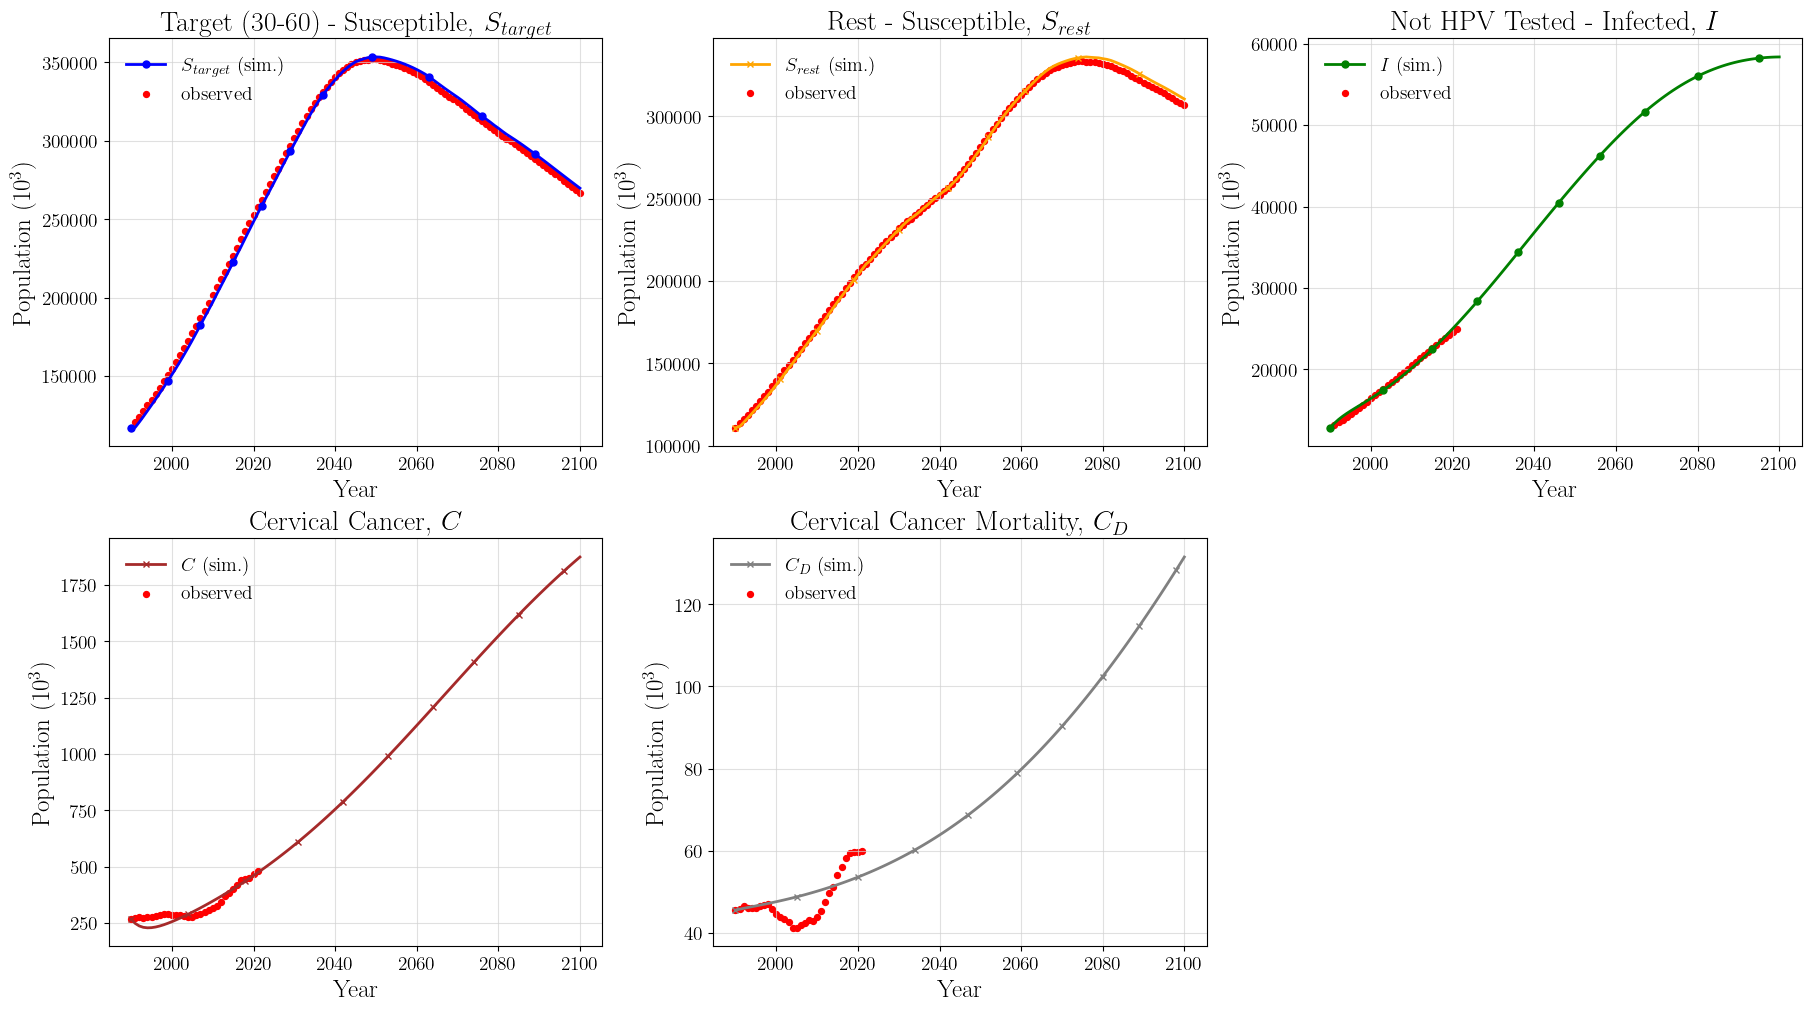

In [31]:
α = lambda t: 0.0   
y0_no = [S_T_obs[0], S_R_obs[0], 0.0, 0.0, I_obs[0], C_obs[0], 0.0, 0.0, CD_obs[0]]
sol_no = odeint(model, y0_no, years, args=(par,))
S_T_n, S_Rest_n, _, _, I_n, C_n, _, _, C_D_n = sol_no.T   # only the 5 series we need

series   = [(S_T_n  , S_T_obs , '$S_{target}$' , 'Target (30-60) - Susceptible,  $S_{target}$',     'blue'  , 'o'),
            (S_Rest_n, S_R_obs, '$S_{rest}$'   , 'Rest - Susceptible, $S_{rest}$',       'orange', 'x'),
            (I_n     , I_obs  , '$I$'          , 'Not HPV Tested - Infected, $I$', 'green' , 'o'),
            (C_n     , C_obs  , '$C$'          , 'Cervical Cancer, $C$'  , 'brown' , 'x'),
            (C_D_n   , CD_obs , '$C_D$'        , 'Cervical Cancer Mortality, $C_D$'       , 'grey'  , 'x')]


fig, axs = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axs = axs.flatten()  # Flatten to access via 1D index

for ax, (mod, obs, mathlab, title, col, mark) in zip(axs[:5], series):
    ax.plot(years, mod, label=f'{mathlab} (sim.)', color=col, marker=mark)
    ax.scatter(years[:len(obs)], obs, s=18, color='red', label='observed')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('Population (10$^{3}$)')
    ax.legend()
    ax.grid(True, which='both', color='lightgray', alpha=0.7)
    


# Leave the 6th subplot empty
axs[5].axis('off')

# Save the 2x3 grid as a single PDF
fig.savefig('no_screening_2x3_grid.pdf', dpi=300)
plt.show()

names = ['S_target_no_screen.pdf', 'S_rest_no_screen.pdf',
         'I_no_screen.pdf', 'C_no_screen.pdf', 'C_D_no_screen.pdf']

for (mod, obs, mathlab, title, col, mark), fname in zip(series, names):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(years, mod, label=f'{mathlab} (sim.)', color=col, marker=mark)
    ax.scatter(years[:len(obs)], obs, s=18, color='red', label='observed')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('Population (10$^{3}$)')
    ax.legend()
    ax.grid(True, which='both', color='lightgray', alpha=0.7)
    fig.savefig(fname, dpi=300)
    plt.close(fig)

## Alpha Sweep (Different Screening Rates), HPV Testing starts in 2025

Also have the option to change the Target screening age band here

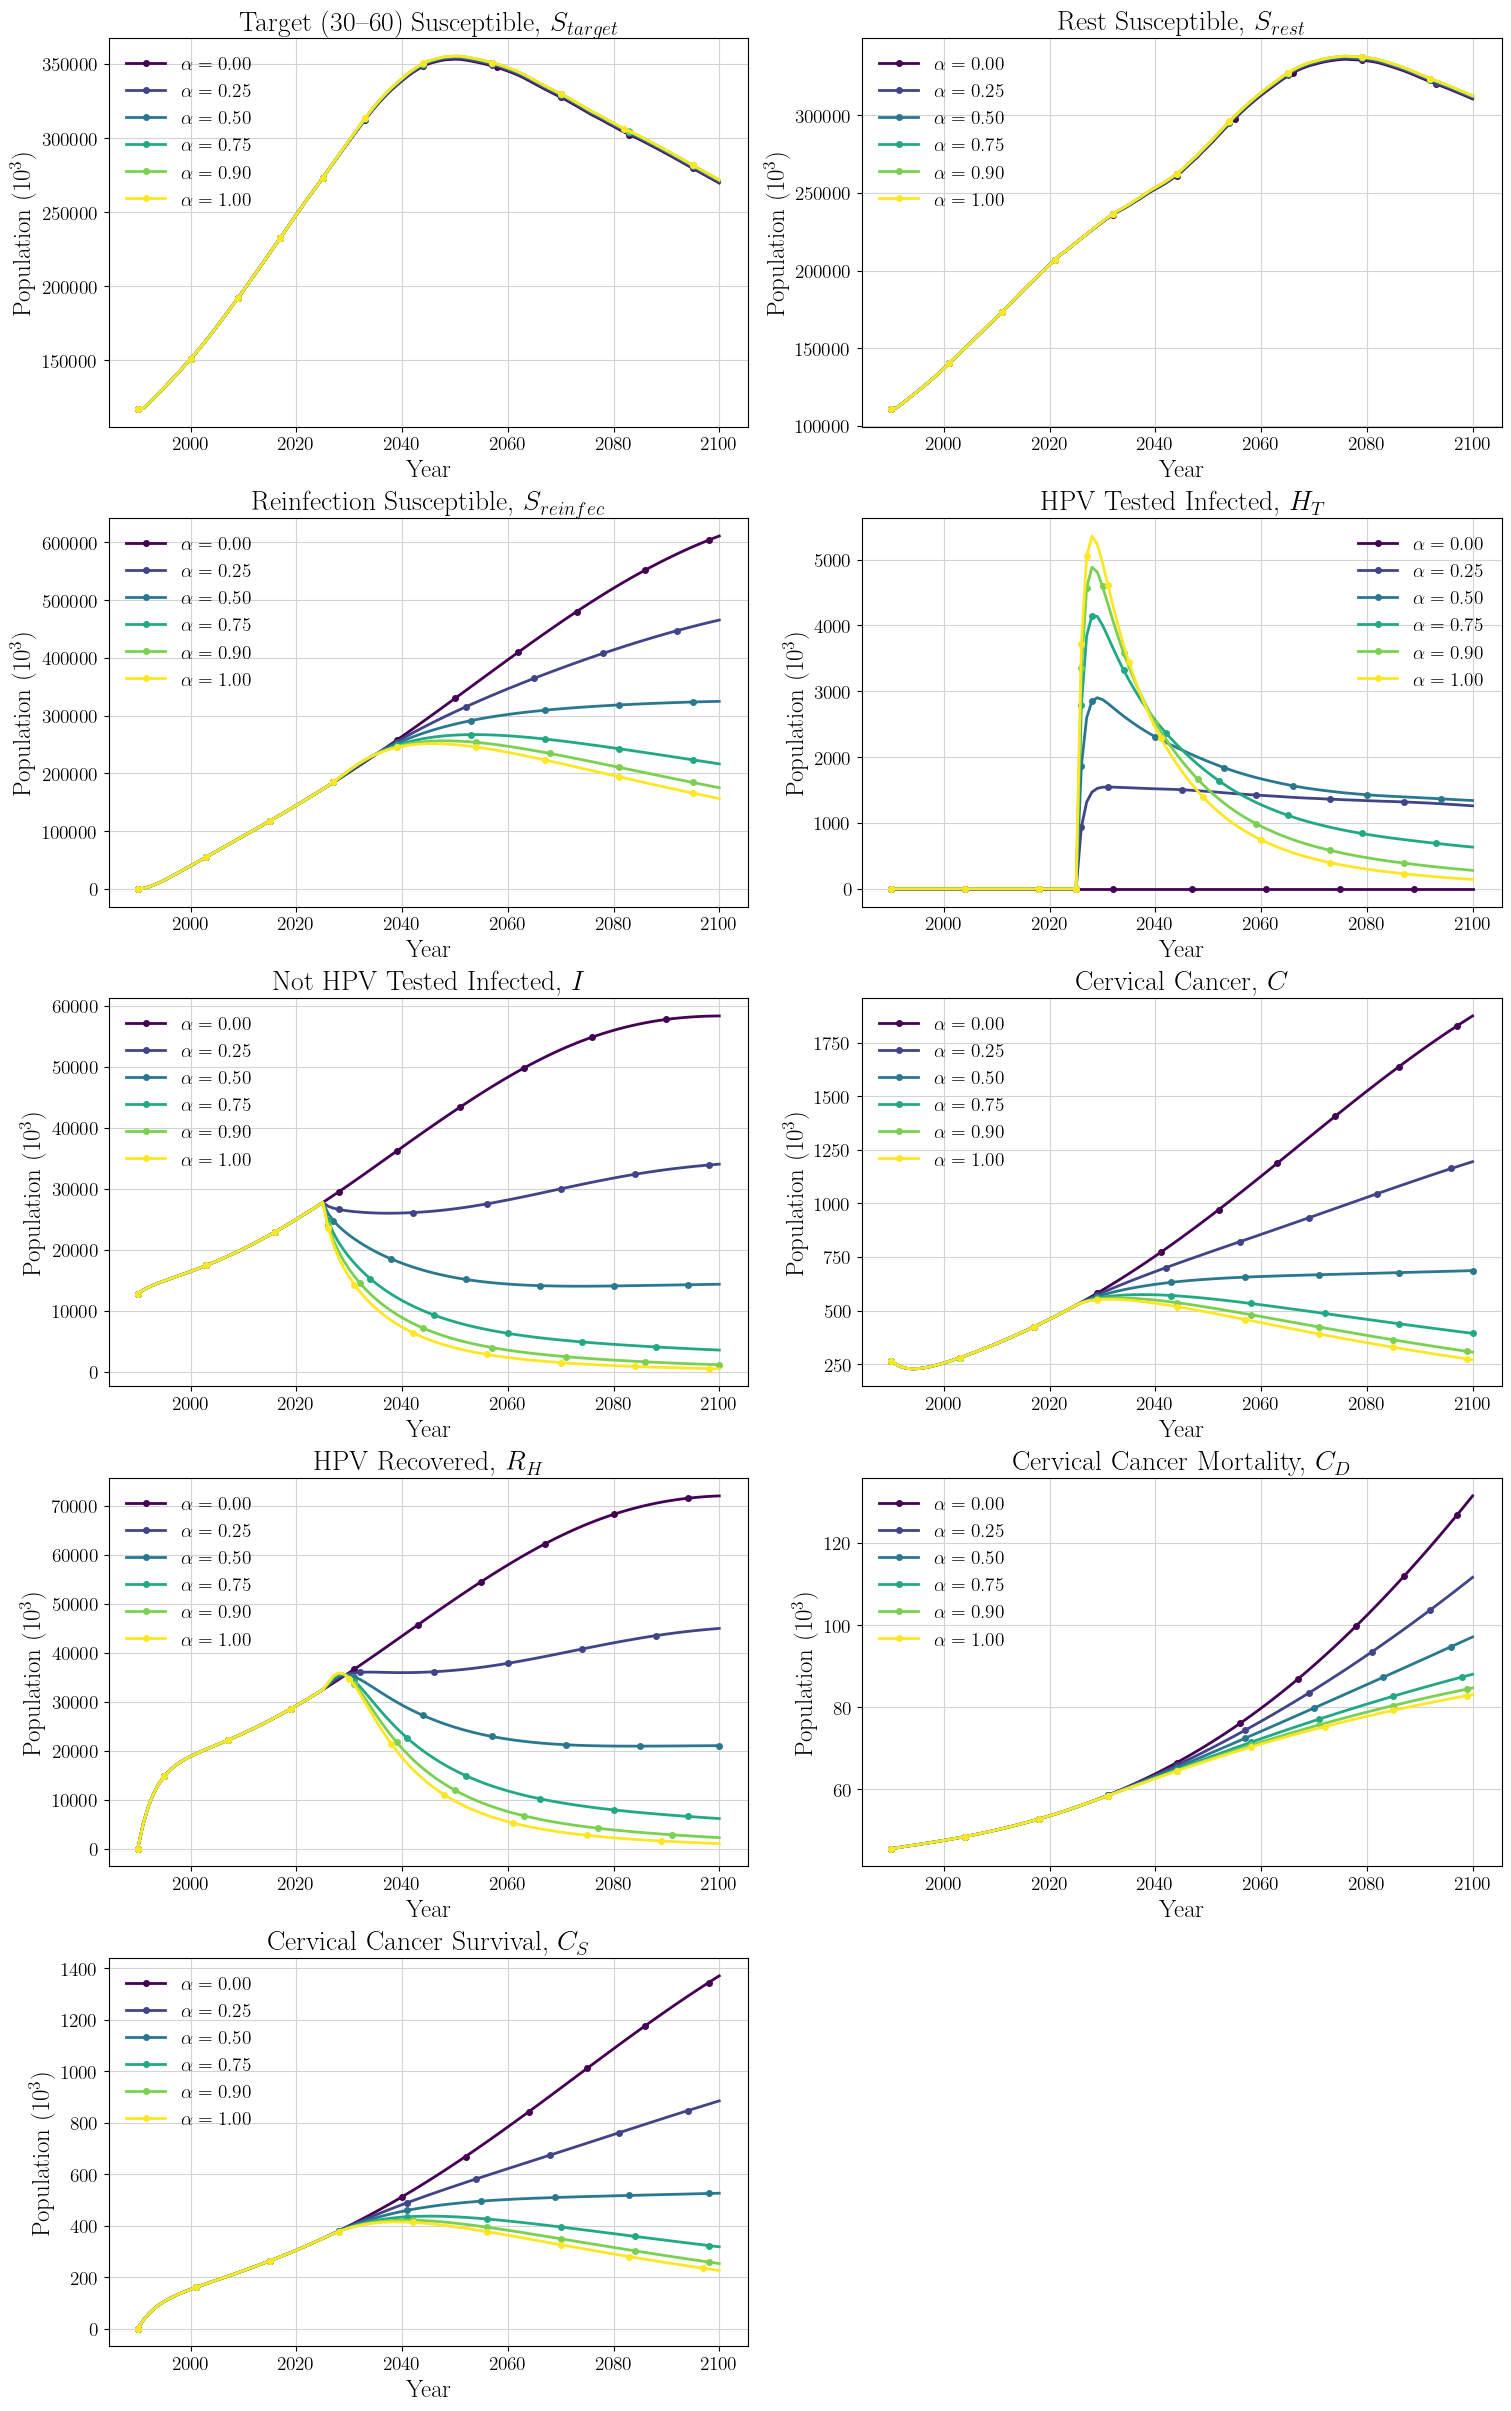

In [5]:
SWEEP_TARGET_LO, SWEEP_TARGET_HI = 30, 60     
SWEEP_SCR_START                  = 2025       
alpha_vals = [0.00, 0.25, 0.50, 0.75, 0.90, 1.00]
colors     = plt.cm.viridis(np.linspace(0, 1, len(alpha_vals)))

ages_sw       = np.arange(TOTAL_LO, TOTAL_HI + 1)
idx_tgt_sw    = [a for a in ages_sw if SWEEP_TARGET_LO <= a <= SWEEP_TARGET_HI]
idx_rst_sw    = [a for a in ages_sw if a not in idx_tgt_sw]

pop_T_sw = {yr: sum_cols(r, [f"Age{a}" for a in idx_tgt_sw ])
            for yr, r in df_pop.set_index("Time").iterrows()}
pop_R_sw = {yr: sum_cols(r, [f"Age{a}" for a in idx_rst_sw ])
            for yr, r in df_pop.set_index("Time").iterrows()}

lam_T_sw = {yr: sum_cols(r, [f"Age{a}" for a in idx_tgt_sw ])
            for yr, r in df_λ .set_index("Time").iterrows()}
lam_R_sw = {yr: sum_cols(r, [f"Age{a}" for a in idx_rst_sw ])
            for yr, r in df_λ .set_index("Time").iterrows()}
Λ_T_sw = lambda t: lam_T_sw[int(np.clip(np.floor(t), λ_min, λ_max))]
Λ_R_sw = lambda t: lam_R_sw[int(np.clip(np.floor(t), λ_min, λ_max))]

p_sw, P_sw = df_p["p"].values, df_p["P"].values
p_T_sw, p_R_sw = p_sw[idx_tgt_sw].sum(), p_sw[idx_rst_sw].sum()
P_T_sw, P_R_sw = P_sw[idx_tgt_sw].sum(), P_sw[idx_rst_sw].sum()

S_T_obs_sw = np.array([pop_T_sw[yr] for yr in years])
S_R_obs_sw = np.array([pop_R_sw[yr] for yr in years])


def make_alpha(cov):
    """Return α(t) that switches from 0→cov in SWEEP_SCR_START."""
    return lambda τ: 0.0 if τ < SWEEP_SCR_START else cov

def model_sw(state, t, p, α_func):
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = state
    N   = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T = p['beta']   * (I + H_T) / N
    iRE = p['beta_R'] * (I + H_T) / N

    a_t  = α_func(t)                          # α for this coverage
    a_Rt = α_R(t)                             # reinfection coverage (unchanged)

    dS_T   = Λ_T_sw(t)*p_T_sw - ((a_t*p['H_pos'] + 1-a_t)*λ_T + P_T_sw) * S_T
    dS_Rst = Λ_R_sw(t)*p_R_sw - (λ_T + P_R_sw) * S_Rest
    dS_R   = p['epsilon']*R_H - ((a_Rt*p['H_pos'] + 1-a_Rt)*iRE + p['mu']) * S_R

    infl_HT = a_t *p['H_pos']*λ_T*S_T + a_Rt*p['H_pos']*iRE*S_R
    infl_I  = (1-a_t)*λ_T*S_T + λ_T*S_Rest + (1-a_Rt)*iRE*S_R

    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu']) * H_T
    dI   = infl_I  - (p['gamma'] + p['r_I'] + p['mu']) * I

    dC   = p['theta']*H_T + p['gamma']*I + p['omega']*C_S - (p['r_C'] + p['mu'] + p['mu_C']) * C
    dR_H = p['r_H']*H_T + p['r_I']*I - (p['epsilon'] + p['mu']) * R_H
    dC_S = p['r_C']*C - (p['omega'] + p['mu']) * C_S
    dC_D = p['mu_C']*C
    return [dS_T, dS_Rst, dS_R, dH_T, dI, dC, dR_H, dC_S, dC_D]


solutions = []
y0_sw = [S_T_obs_sw[0], S_R_obs_sw[0], 0, 0,
         I_obs[0], C_obs[0], 0, 0, CD_obs[0]]

for cov, col in zip(alpha_vals, colors):
    α_func = make_alpha(cov)
    sol    = odeint(model_sw, y0_sw, years, args=(par, α_func))
    solutions.append(sol.T)

titles = [
    r'Target (%d–%d) Susceptible, $S_{target}$' % (SWEEP_TARGET_LO, SWEEP_TARGET_HI),
    r'Rest Susceptible, $S_{rest}$',
    r'Reinfection Susceptible, $S_{reinfec}$',
    r'HPV Tested Infected, $H_T$',
    r'Not HPV Tested Infected, $I$',
    r'Cervical Cancer, $C$',
    r'HPV Recovered, $R_H$',
    r'Cervical Cancer Mortality, $C_D$',
    r'Cervical Cancer Survival, $C_S$'
]
comp_idx = [0, 1, 2, 3, 4, 5, 6, 8, 7]

fig, axs = plt.subplots(5, 2, figsize=(15, 24), constrained_layout=True)
axs = axs.flatten()

for k, idx in enumerate(comp_idx):
    ax = axs[k]
    for sol, col, cov in zip(solutions, colors, alpha_vals):
        ax.plot(
            years,
            sol[idx],
            color=col,
            linestyle='-',        # Solid line
            marker='o',           # Uniform dot marker
            markersize=4,         # Optional: tweak marker size
#             markerfacecolor='white',  # Optional: hollow center
            label=fr'$\alpha={cov:.2f}$'
        )
    ax.set_title(titles[k])
    ax.set_xlabel('Year')
    ax.set_ylabel('Population (10$^{3}$)')
    ax.legend()
    ax.grid(True)
    
axs[9].axis('off')

# Save and show plot
fig.savefig('alpha_sweep.pdf', dpi=300)
plt.show()

## Target-Age Sweep (Different Target Age Groups), HPV Testing starts at 2025

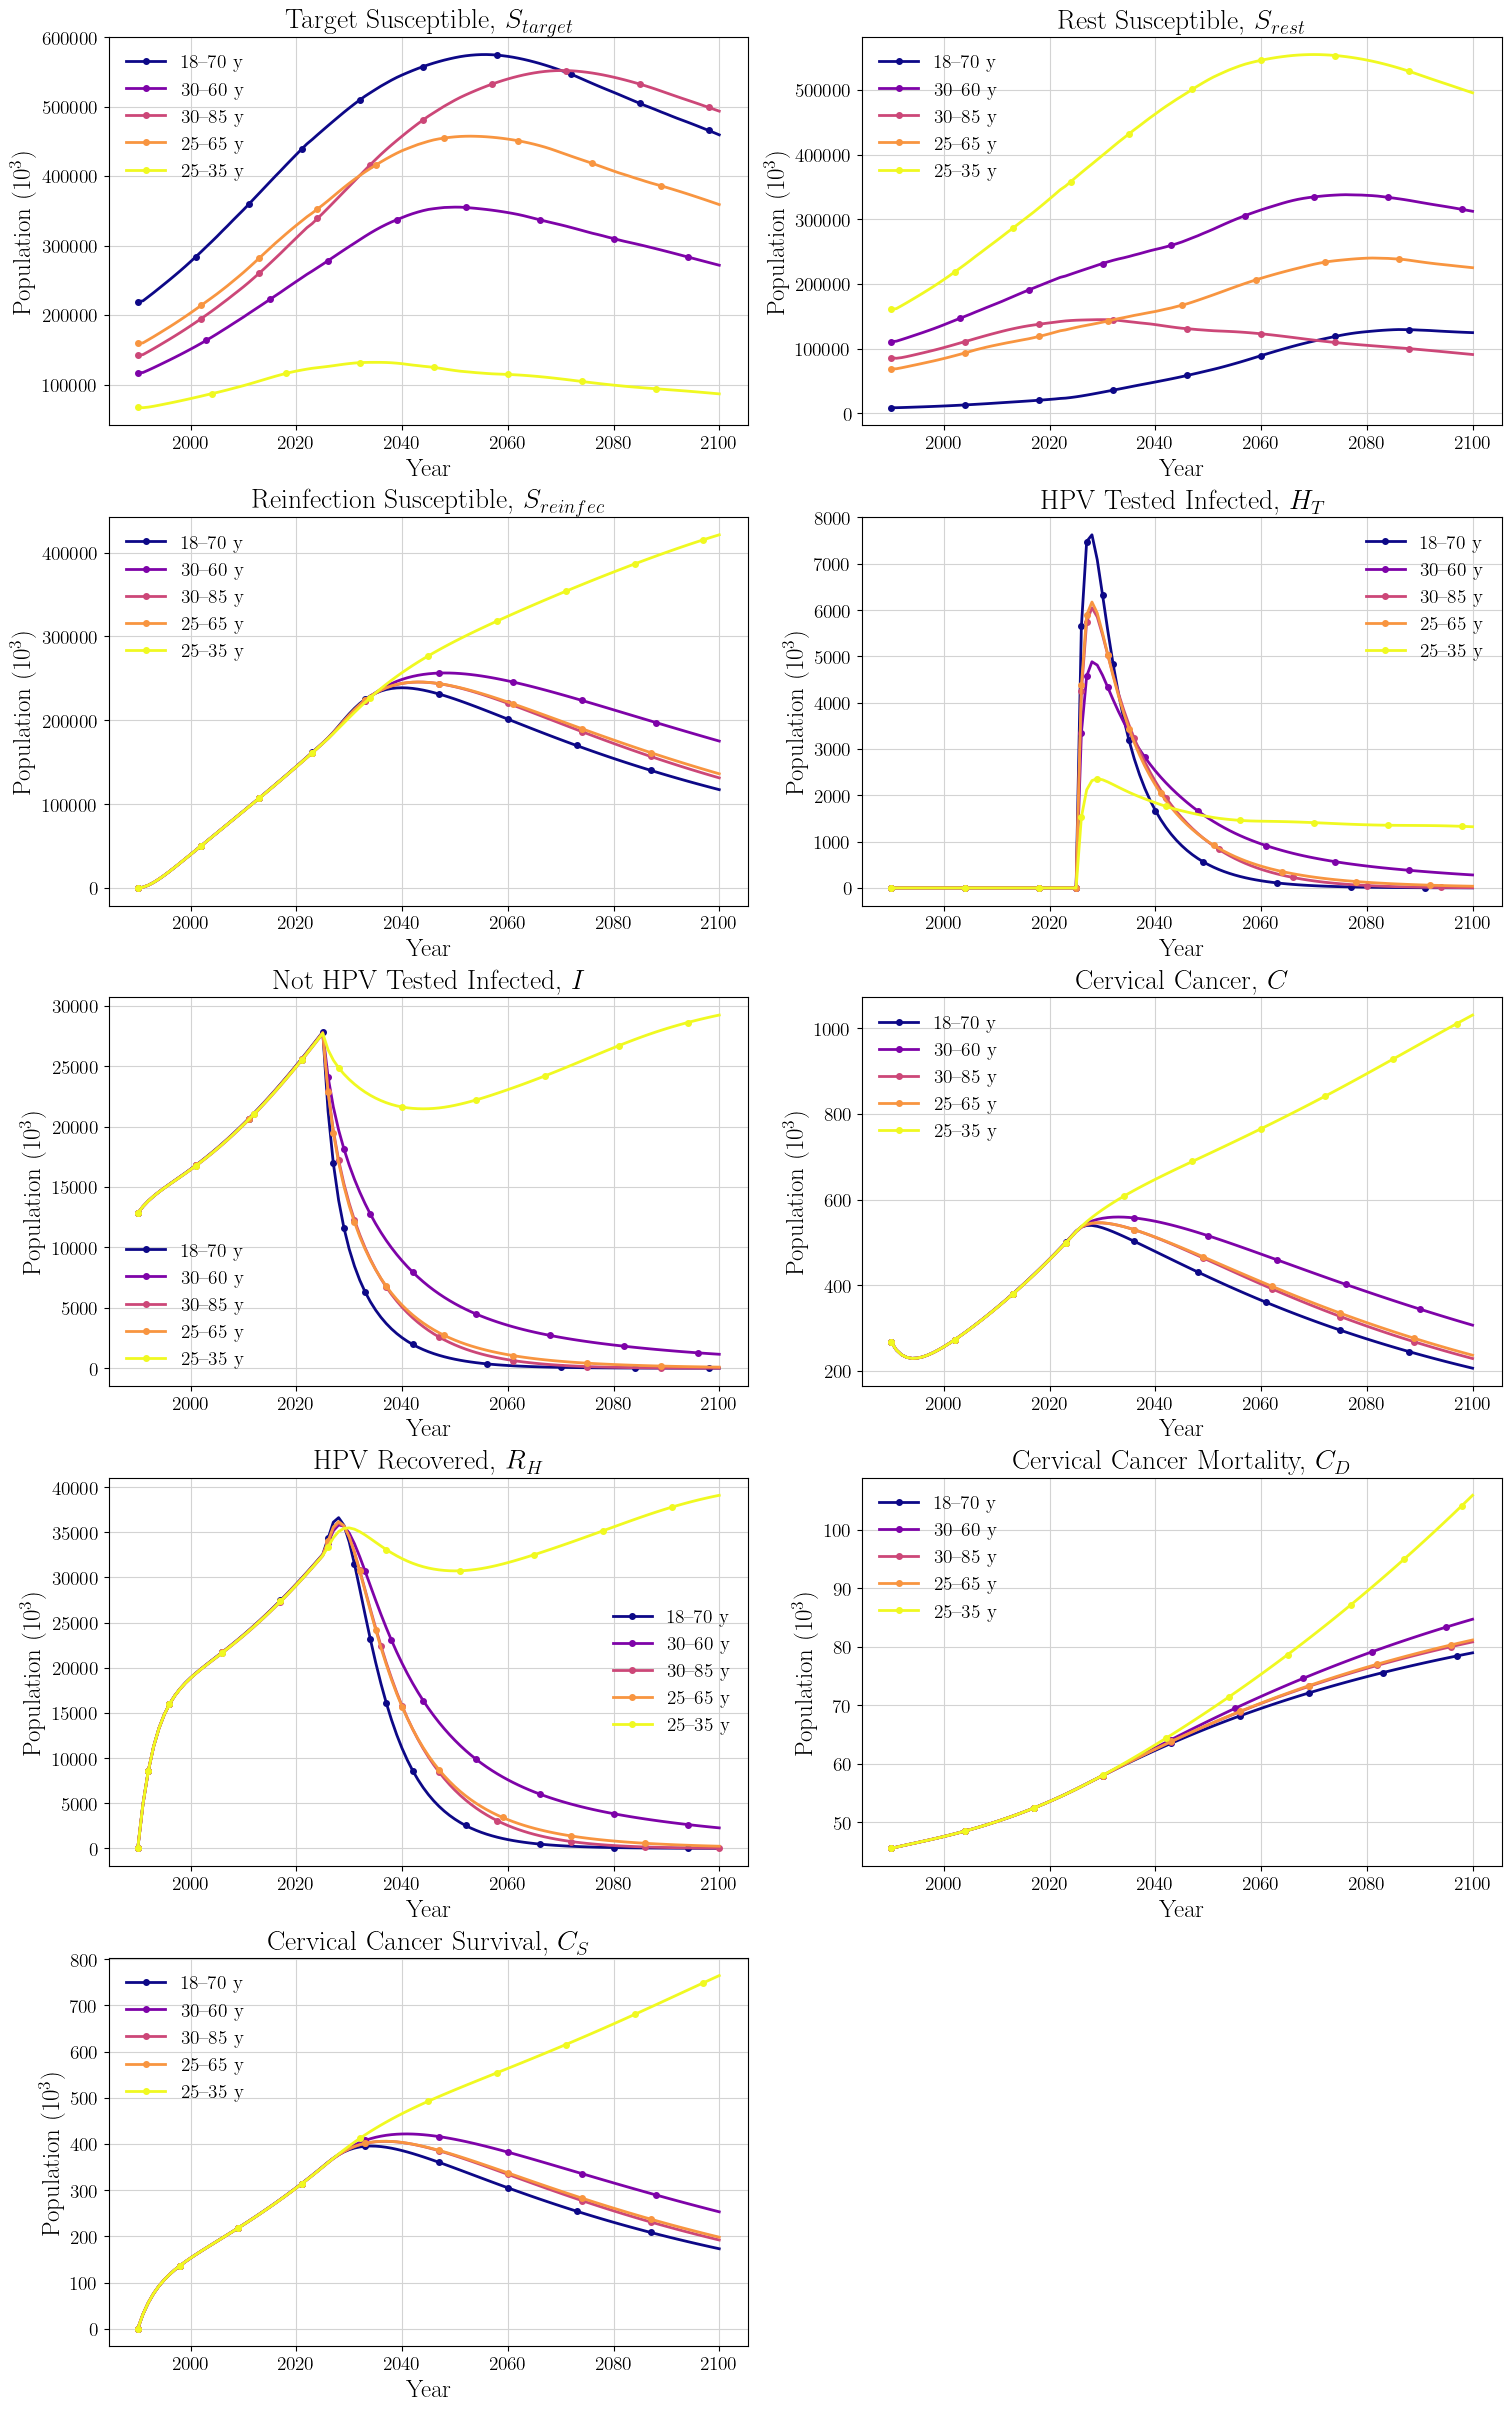

In [6]:
BANDS = [(18, 70), (30, 60), (30, 85), (25, 65), (25, 35)]
SWEEP_SCR_START = 2025          # year α becomes > 0
ALPHA_COVERAGE  = 0.90          # fixed α for all bands

colors = plt.cm.plasma(np.linspace(0, 1, len(BANDS)))  # Changed to 'Paired'

def make_alpha(cov):
    """Return α(t) with step up at SWEEP_SCR_START."""
    return lambda τ: 0.0 if τ < SWEEP_SCR_START else cov

def band_quantities(lo, hi):
    """Λ_T, Λ_R, p_T, p_R, P_T, P_R, initial populations for one band."""
    idx_tgt = [a for a in range(TOTAL_LO, TOTAL_HI+1) if lo <= a <= hi]
    idx_rst = [a for a in range(TOTAL_LO, TOTAL_HI+1) if a not in idx_tgt]

    pop_T = {yr: sum_cols(r, [f"Age{a}" for a in idx_tgt])
             for yr, r in df_pop.set_index("Time").iterrows()}
    pop_R = {yr: sum_cols(r, [f"Age{a}" for a in idx_rst])
             for yr, r in df_pop.set_index("Time").iterrows()}

    lam_T = {yr: sum_cols(r, [f"Age{a}" for a in idx_tgt])
             for yr, r in df_λ.set_index("Time").iterrows()}
    lam_R = {yr: sum_cols(r, [f"Age{a}" for a in idx_rst])
             for yr, r in df_λ.set_index("Time").iterrows()}
    Λ_T = lambda t: lam_T[int(np.clip(np.floor(t), λ_min, λ_max))]
    Λ_R = lambda t: lam_R[int(np.clip(np.floor(t), λ_min, λ_max))]

    p_arr, P_arr = df_p["p"].values, df_p["P"].values
    p_T, p_R = p_arr[idx_tgt].sum(), p_arr[idx_rst].sum()
    P_T, P_R = P_arr[idx_tgt].sum(), P_arr[idx_rst].sum()

    ST0 = pop_T[START_YEAR]
    SR0 = pop_R[START_YEAR]

    return Λ_T, Λ_R, p_T, p_R, P_T, P_R, ST0, SR0, pop_T, pop_R

def model_band(state, t, p, α_func, Λ_T, Λ_R, p_T, p_R, P_T, P_R):
    """ODEs for a *specific* band (inject its Λ / p / P)."""
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = state
    N   = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T = p['beta']   * (I + H_T) / N
    iRE = p['beta_R'] * (I + H_T) / N

    a_t  = α_func(t)
    a_Rt = α_R(t)                 # reinfection coverage (unchanged)

    dS_T   = Λ_T(t)*p_T - ((a_t*p['H_pos'] + 1-a_t)*λ_T + P_T) * S_T
    dS_Rst = Λ_R(t)*p_R - (λ_T + P_R) * S_Rest
    dS_R   = p['epsilon']*R_H - ((a_Rt*p['H_pos'] + 1-a_Rt)*iRE + p['mu']) * S_R

    infl_HT = a_t *p['H_pos']*λ_T*S_T + a_Rt*p['H_pos']*iRE*S_R
    infl_I  = (1-a_t)*λ_T*S_T + λ_T*S_Rest + (1-a_Rt)*iRE*S_R

    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu']) * H_T
    dI   = infl_I  - (p['gamma'] + p['r_I'] + p['mu']) * I

    dC   = p['theta']*H_T + p['gamma']*I + p['omega']*C_S - (p['r_C'] + p['mu'] + p['mu_C']) * C
    dR_H = p['r_H']*H_T + p['r_I']*I - (p['epsilon'] + p['mu']) * R_H
    dC_S = p['r_C']*C - (p['omega'] + p['mu']) * C_S
    dC_D = p['mu_C']*C
    return [dS_T, dS_Rst, dS_R, dH_T, dI, dC, dR_H, dC_S, dC_D]

solutions, pop_series, legends = [], [], []

for (lo, hi), col in zip(BANDS, colors):
    Λ_T, Λ_R, p_T, p_R, P_T, P_R, ST0, SR0, pop_T_dict, pop_R_dict = band_quantities(lo, hi)
    α_func = make_alpha(ALPHA_COVERAGE)

    y0_band = [ST0, SR0, 0, 0, I_obs[0], C_obs[0], 0, 0, CD_obs[0]]
    sol     = odeint(model_band, y0_band, years,
                     args=(par, α_func, Λ_T, Λ_R, p_T, p_R, P_T, P_R))
    solutions.append(sol.T)
    pop_series.append( (np.array([pop_T_dict[y] for y in years]),
                        np.array([pop_R_dict[y] for y in years])) )
    legends.append(f'{lo}–{hi} y')

titles = [
    r'Target Susceptible, $S_{target}$',
    r'Rest Susceptible, $S_{rest}$',
    r'Reinfection Susceptible, $S_{reinfec}$',
    r'HPV Tested Infected, $H_T$',
    r'Not HPV Tested Infected, $I$',
    r'Cervical Cancer, $C$',
    r'HPV Recovered, $R_H$',
    r'Cervical Cancer Mortality, $C_D$',
    r'Cervical Cancer Survival, $C_S$'
]
comp_idx = [0,1,2,3,4,5,6,8,7]

# Plotting
fig, axs = plt.subplots(5, 2, figsize=(15, 24), constrained_layout=True)
axs = axs.flatten()

for k, idx in enumerate(comp_idx):
    ax = axs[k]
    for sol, col, lab in zip(solutions, colors, legends):
        ax.plot(
            years,
            sol[idx],
            color=col,
            linestyle='-',      # Solid line
            marker='o',         # Solid dot marker
            markersize=4,
            label=lab
        )
    ax.set_title(titles[k])
    ax.set_xlabel('Year')
    ax.set_ylabel('Population (10$^{3}$)')
    ax.legend()
    ax.grid(True)

axs[9].axis('off')  # Hide unused subplot
fig.savefig('target_band_sweep.pdf', dpi=300)
plt.show()

## $\theta$ Sweep, by having $\theta = \gamma/\pi$, and sweeping through different values of $\pi$

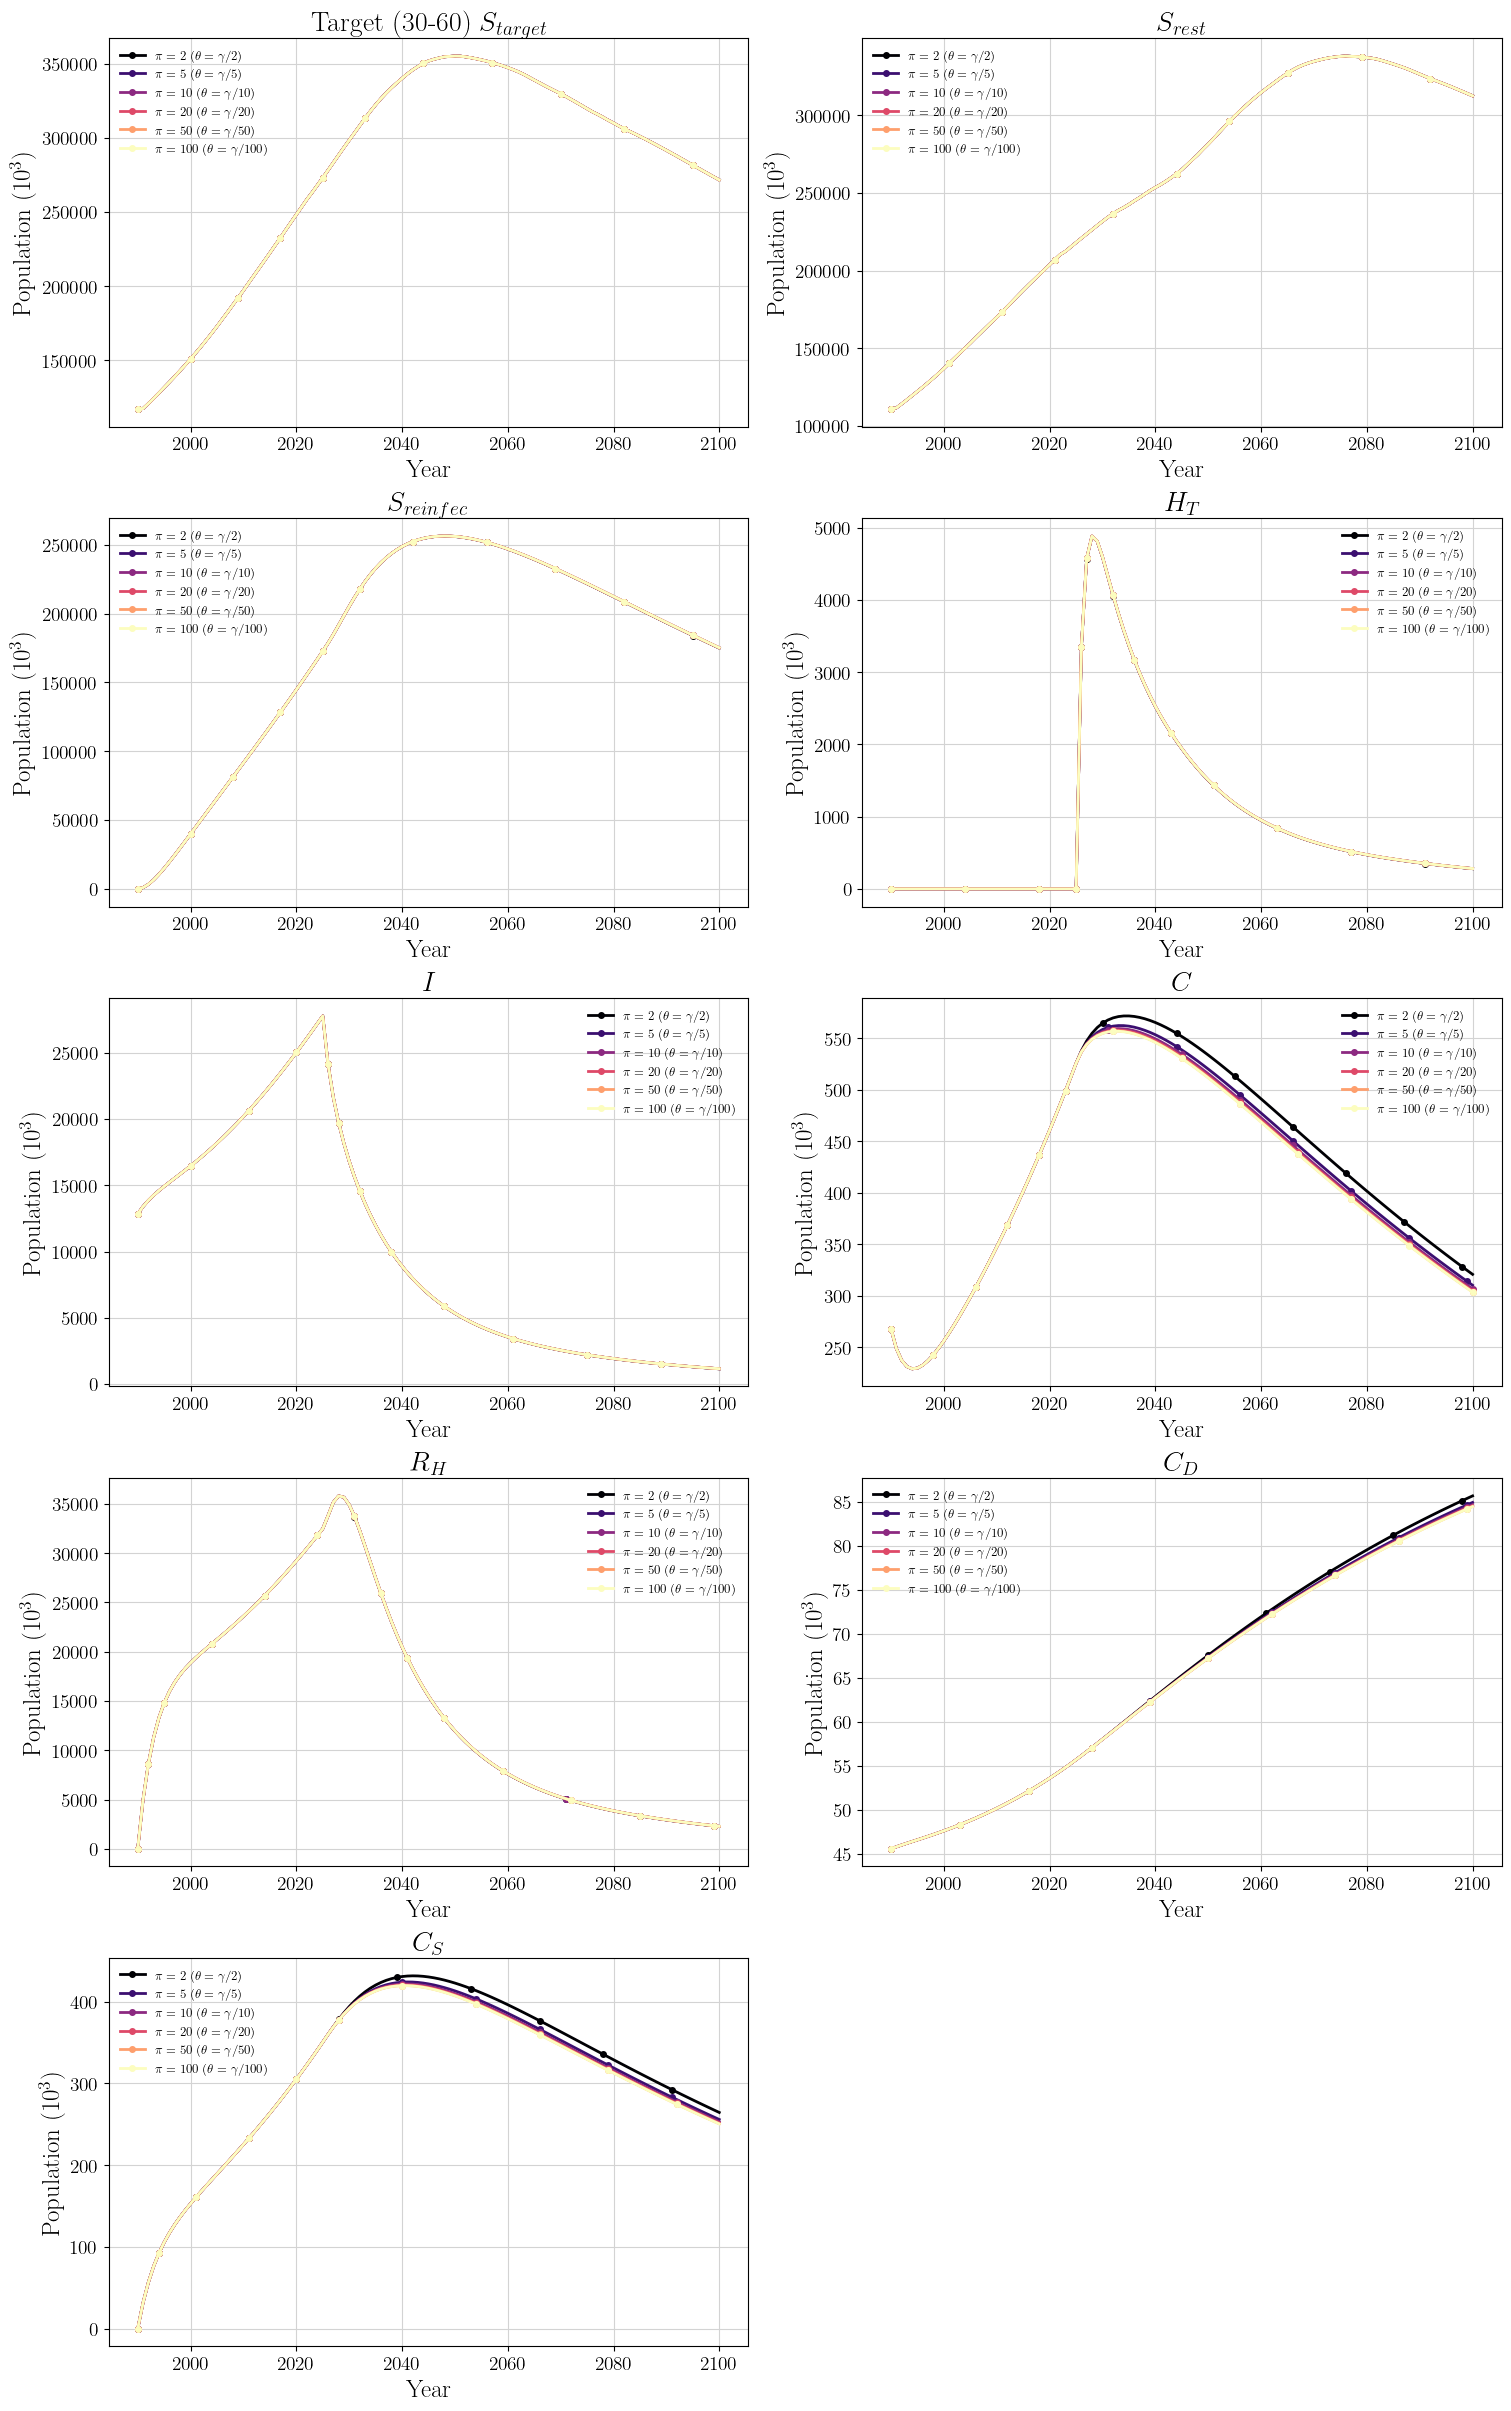

In [7]:
SWEEP_PI          = [2, 5, 10, 20, 50, 100]
SWEEP_SCR_START   = 2025
SWEEP_ALPHA_CONST = 0.90
# ————————————————————————————————————————————————————————

colors = plt.cm.magma(np.linspace(0, 1, len(SWEEP_PI)))

# ----- age-tables (unchanged) ------------------------------------------
ages_sw    = np.arange(TOTAL_LO, TOTAL_HI+1)
idx_tgt_sw = [a for a in ages_sw if SWEEP_TARGET_LO <= a <= SWEEP_TARGET_HI]
idx_rst_sw = [a for a in ages_sw if a not in idx_tgt_sw]

pop_T_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt_sw])
            for yr,r in df_pop.set_index("Time").iterrows()}
pop_R_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst_sw])
            for yr,r in df_pop.set_index("Time").iterrows()}

lam_T_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt_sw])
            for yr,r in df_λ.set_index("Time").iterrows()}
lam_R_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst_sw])
            for yr,r in df_λ.set_index("Time").iterrows()}
Λ_T_sw = lambda t: lam_T_sw[int(np.clip(np.floor(t), λ_min, λ_max))]
Λ_R_sw = lambda t: lam_R_sw[int(np.clip(np.floor(t), λ_min, λ_max))]

p_sw, P_sw  = df_p["p"].values, df_p["P"].values
p_T_sw, p_R_sw = p_sw[idx_tgt_sw].sum(), p_sw[idx_rst_sw].sum()
P_T_sw, P_R_sw = P_sw[idx_tgt_sw].sum(), P_sw[idx_rst_sw].sum()

S_T_obs_sw = np.array([pop_T_sw[yr] for yr in years])
S_R_obs_sw = np.array([pop_R_sw[yr] for yr in years])

# ---------- constant-α profile -----------------------------------------
alpha_const = lambda t: 0.0 if t < SWEEP_SCR_START else SWEEP_ALPHA_CONST

# ---------- RHS ---------------------------------------------------------
def model_theta(state, t, p, α_func):
    S_T,S_Rest,S_R,H_T,I,C,R_H,C_S,C_D = state
    N   = S_T+S_Rest+S_R+H_T+I+C+R_H+C_S+C_D
    λ_T = p['beta']   * (I+H_T)/N
    iRE = p['beta_R'] * (I+H_T)/N
    a_t = α_func(t)

    dS_T   = Λ_T_sw(t)*p_T_sw - ((a_t*p['H_pos'] + 1-a_t)*λ_T + P_T_sw) * S_T
    dS_Rst = Λ_R_sw(t)*p_R_sw - (λ_T + P_R_sw) * S_Rest
    dS_R   = p['epsilon']*R_H - (iRE + p['mu']) * S_R
    infl_HT= a_t*p['H_pos']*λ_T*S_T
    infl_I =(1-a_t)*λ_T*S_T + λ_T*S_Rest + iRE*S_R
    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu'])*H_T
    dI   = infl_I  - (p['gamma'] + p['r_I'] + p['mu'])*I
    dC   = p['theta']*H_T + p['gamma']*I + p['omega']*C_S - (p['r_C']+p['mu']+p['mu_C'])*C
    dR_H = p['r_H']*H_T + p['r_I']*I - (p['epsilon']+p['mu'])*R_H
    dC_S = p['r_C']*C - (p['omega']+p['mu'])*C_S
    dC_D = p['mu_C']*C
    return [dS_T,dS_Rst,dS_R,dH_T,dI,dC,dR_H,dC_S,dC_D]

# ---------- integrate for every π --------------------------------------
solutions=[]
for π in SWEEP_PI:
    p_tmp = par.copy()
    p_tmp['theta'] = p_tmp['gamma'] / π
    y0    = [S_T_obs_sw[0], S_R_obs_sw[0], 0, 0,
             I_obs[0],      C_obs[0],      0, 0, CD_obs[0]]
    sol   = odeint(model_theta, y0, years, args=(p_tmp, alpha_const))
    solutions.append(sol.T)

# ---------- plotting ----------------------------------------------------
titles = [
    fr'Target ({SWEEP_TARGET_LO}-{SWEEP_TARGET_HI}) $S_{{target}}$',
    r'$S_{rest}$', r'$S_{reinfec}$', r'$H_T$',
    r'$I$', r'$C$', r'$R_H$', r'$C_D$', r'$C_S$'
]
order=[0,1,2,3,4,5,6,8,7]

fig,axs=plt.subplots(5,2,figsize=(15,24),constrained_layout=True)
axs=axs.flatten()
for pane,idx in enumerate(order):
    for sol,col,π in zip(solutions,colors,SWEEP_PI):
        axs[pane].plot(years, sol[idx],
                       color=col,
                       linestyle='-',   # ←—— solid line ★
                       marker='o', ms=4,
                       label=fr'$\pi={π}\;(\theta=\gamma/{π})$')
    axs[pane].set_title(titles[pane])
    axs[pane].set_xlabel('Year'); axs[pane].set_ylabel('Population (10$^{3}$)')
    axs[pane].grid(True); axs[pane].legend(fontsize=9)
axs[9].axis('off')

#sup = rf'HPV testing rate fixed at $\alpha={SWEEP_ALPHA_CONST:.2f}$ | start={SWEEP_SCR_START}'
#plt.suptitle(sup, y=0.92, fontsize=16)
plt.savefig('theta_sweep_pi.pdf', dpi=300)
plt.show()

## $R_H$ Sweep, by having $R_H = 0.50,0.60,0.70,0.80,0.90$

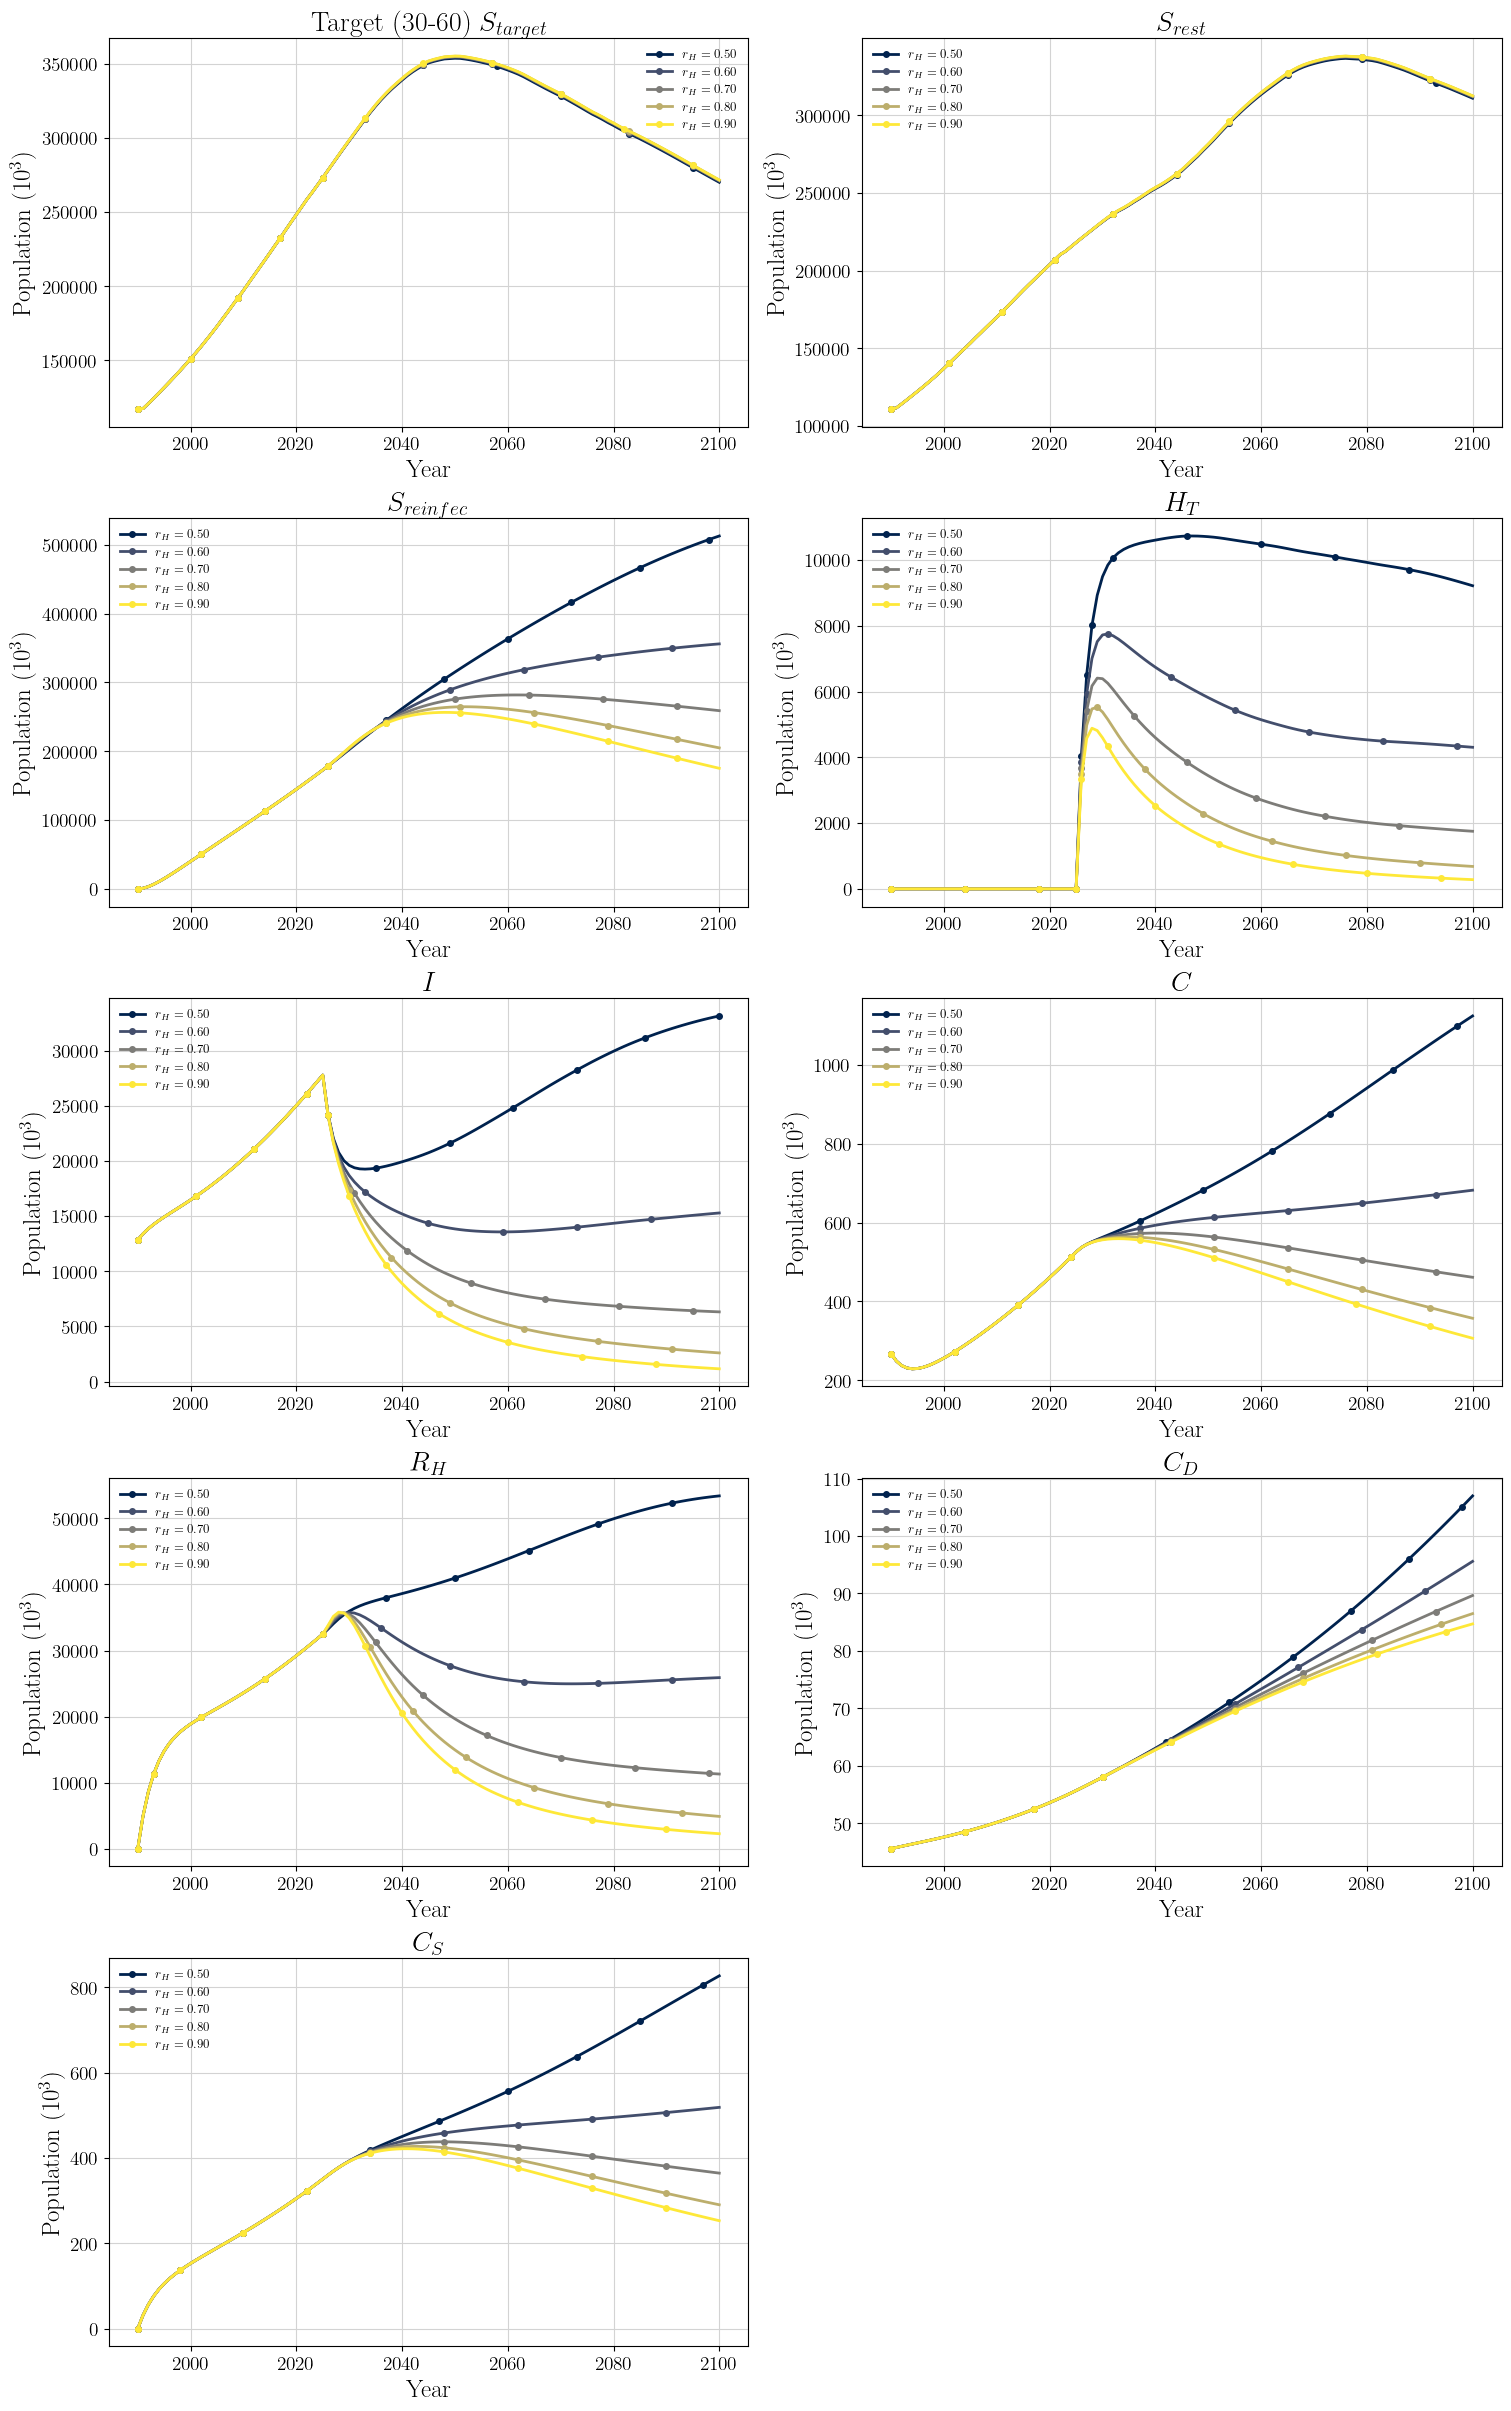

In [8]:
RH_VALUES         = [0.50, 0.60, 0.70, 0.80, 0.90]   # sweep set
SWEEP_SCR_START   = 2025
SWEEP_ALPHA_CONST = 0.90                             # fixed testing coverage
# ————————————————————————————————————————————————————————

colors = plt.cm.cividis(np.linspace(0, 1, len(RH_VALUES)))  # different map

# ----- age tables (same as previous cell) ------------------------------
ages_sw    = np.arange(TOTAL_LO, TOTAL_HI+1)
idx_tgt_sw = [a for a in ages_sw if SWEEP_TARGET_LO <= a <= SWEEP_TARGET_HI]
idx_rst_sw = [a for a in ages_sw if a not in idx_tgt_sw]

pop_T_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt_sw])
            for yr,r in df_pop.set_index("Time").iterrows()}
pop_R_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst_sw])
            for yr,r in df_pop.set_index("Time").iterrows()}

lam_T_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt_sw])
            for yr,r in df_λ.set_index("Time").iterrows()}
lam_R_sw = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst_sw])
            for yr,r in df_λ.set_index("Time").iterrows()}
Λ_T_sw = lambda t: lam_T_sw[int(np.clip(np.floor(t), λ_min, λ_max))]
Λ_R_sw = lambda t: lam_R_sw[int(np.clip(np.floor(t), λ_min, λ_max))]

p_sw, P_sw   = df_p["p"].values, df_p["P"].values
p_T_sw, p_R_sw = p_sw[idx_tgt_sw].sum(), p_sw[idx_rst_sw].sum()
P_T_sw, P_R_sw = P_sw[idx_tgt_sw].sum(), P_sw[idx_rst_sw].sum()

S_T_obs_sw = np.array([pop_T_sw[yr] for yr in years])
S_R_obs_sw = np.array([pop_R_sw[yr] for yr in years])

# ---------- constant-α profile -----------------------------------------
alpha_const = lambda t: 0.0 if t < SWEEP_SCR_START else SWEEP_ALPHA_CONST

# ---------- RHS ---------------------------------------------------------
def model_rH(state, t, p, α_func):
    S_T,S_Rest,S_R,H_T,I,C,R_H,C_S,C_D = state
    N   = S_T+S_Rest+S_R+H_T+I+C+R_H+C_S+C_D
    λ_T = p['beta']   * (I+H_T)/N
    iRE = p['beta_R'] * (I+H_T)/N
    a_t = α_func(t)

    dS_T   = Λ_T_sw(t)*p_T_sw - ((a_t*p['H_pos'] + 1-a_t)*λ_T + P_T_sw) * S_T
    dS_Rst = Λ_R_sw(t)*p_R_sw - (λ_T + P_R_sw) * S_Rest
    dS_R   = p['epsilon']*R_H - (iRE + p['mu']) * S_R
    infl_HT= a_t*p['H_pos']*λ_T*S_T
    infl_I =(1-a_t)*λ_T*S_T + λ_T*S_Rest + iRE*S_R
    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu'])*H_T
    dI   = infl_I  - (p['gamma'] + p['r_I'] + p['mu'])*I
    dC   = p['theta']*H_T + p['gamma']*I + p['omega']*C_S - (p['r_C']+p['mu']+p['mu_C'])*C
    dR_H = p['r_H']*H_T + p['r_I']*I - (p['epsilon']+p['mu'])*R_H
    dC_S = p['r_C']*C - (p['omega']+p['mu'])*C_S
    dC_D = p['mu_C']*C
    return [dS_T,dS_Rst,dS_R,dH_T,dI,dC,dR_H,dC_S,dC_D]

# ---------- integrate ---------------------------------------------------
solutions=[]
for rH_val in RH_VALUES:
    p_tmp = par.copy()
    p_tmp['r_H'] = rH_val
    y0    = [S_T_obs_sw[0], S_R_obs_sw[0], 0, 0,
             I_obs[0],      C_obs[0],      0, 0, CD_obs[0]]
    sol   = odeint(model_rH, y0, years, args=(p_tmp, alpha_const))
    solutions.append(sol.T)

# ---------- plotting ----------------------------------------------------
titles = [
    fr'Target ({SWEEP_TARGET_LO}-{SWEEP_TARGET_HI}) $S_{{target}}$',
    r'$S_{rest}$', r'$S_{reinfec}$', r'$H_T$',
    r'$I$', r'$C$', r'$R_H$', r'$C_D$', r'$C_S$'
]
order=[0,1,2,3,4,5,6,8,7]

fig,axs=plt.subplots(5,2,figsize=(15,24),constrained_layout=True)
axs=axs.flatten()
for pane,idx in enumerate(order):
    for sol,col,rH_val in zip(solutions,colors,RH_VALUES):
        axs[pane].plot(years, sol[idx],
                       color=col,
                       linestyle='-',   # solid line
                       marker='o', ms=4,
                       label=fr'$r_H={rH_val:.2f}$')
    axs[pane].set_title(titles[pane])
    axs[pane].set_xlabel('Year'); axs[pane].set_ylabel('Population (10$^{3}$)')
    axs[pane].grid(True); axs[pane].legend(fontsize=9)
axs[9].axis('off')

#sup = rf'HPV testing rate fixed at $\alpha={SWEEP_ALPHA_CONST:.2f}$ | start={SWEEP_SCR_START}'
#plt.suptitle(sup, y=0.92, fontsize=16)
plt.savefig('rH_sweep.pdf', dpi=300)
plt.show()

### Basic Reproduction Number  $\mathcal R_{0}$ 

The basic reproduction number, $\mathcal R_{0}$, measures the
expected number of secondary infections generated by a single infectious
individual in an otherwise susceptible population
([Diekmann 1990](#)).  
We derive $\mathcal R_{0}$ for the HPV-testing model with **no
screening** ($\alpha = 0$), i.e. $H_T\equiv0$.

---

#### Next-generation set-up  

With the infected block  

$$
X = \bigl(
      I,\;
      C,\;
      S_{\text{target}},\;
      S_{\text{rest}},\;
      S_{R},\;
      R_H
    \bigr)^{\mathsf T},
$$

write  

$$
\frac{dX}{dt} = \mathcal F(X) - \mathcal V(X).
$$

*New infections* enter only the \(I\)-equation:

$$
\lambda_H = \beta \frac{I}{N},
\quad
\lambda_R = \beta_R \frac{I}{N},
$$

$$
\mathcal F(X)=
\begin{pmatrix}
  [\,\beta(S_{\text{target}}+S_{\text{rest}})+\beta_R S_R\,]\,
  I/N\\[6pt]
  0\\0\\0\\0\\0
\end{pmatrix}
$$

Everything else is collected in $\mathcal V(X)$ (progression,
recovery, mortality).

---

#### Disease-free equilibrium (DFE)

At the DFE  
$$I=C=R_H=H_T=0$$ and the susceptible stocks are  
$$S_{\text{target}}^{0},\;S_{\text{rest}}^{0},\;S_{R}^{0}$$ with  
$$N^{0}=S_{\text{target}}^{0}+S_{\text{rest}}^{0}+S_{R}^{0}$$

---

#### Jacobian matrices at DFE  

Only the first row of  
$F=\partial\mathcal F/\partial X|_{\text{DFE}}$ is non-zero:

$$
F = \begin{pmatrix}
\frac{\beta(S_{\text{target}}^{0}+S_{\text{rest}}^{0})+\beta_R S_{R}^{0}}{N^{0}} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

The relevant part of  
$V=\partial\mathcal V/\partial X|_{\text{DFE}}$ is the $3\times3$
block for $(I,C,R_H)$:

$$
V=
\begin{pmatrix}
\gamma+r_I+\mu & 0                 & -\varepsilon\\
-\gamma        & r_C+\mu+\mu_C     & 0\\
-r_I           & 0                 & \varepsilon+\mu
\end{pmatrix}
$$

---

#### Next-generation matrix and formula  

Because $F$ has rank 1,  
$K = FV^{-1}$ collapses to a scalar, giving

$$
\boxed{%
  \mathcal R_{0}
  = \frac{
      \beta\,(S_{\text{target}}^{0}+S_{\text{rest}}^{0})
      +\beta_R\,S_{R}^{0}
    }{
      (\gamma+r_I+\mu)\,N^{0}
    }}
$$

or, separating the two infection routes,

$$
\mathcal R_{0}
  = \frac{\beta}{\gamma+r_I+\mu}
    \frac{S_{\text{target}}^{0}+S_{\text{rest}}^{0}}{N^{0}}
  \;+\;
    \frac{\beta_R}{\gamma+r_I+\mu}
    \frac{S_{R}^{0}}{N^{0}}.
$$

* If  $\mathcal R_{0} < 1$ the disease-free equilibrium is **stable**
  (infections die out).  
* If $\mathcal R_{0} > 1$ the equilibrium is **unstable** and the
  infection can invade.

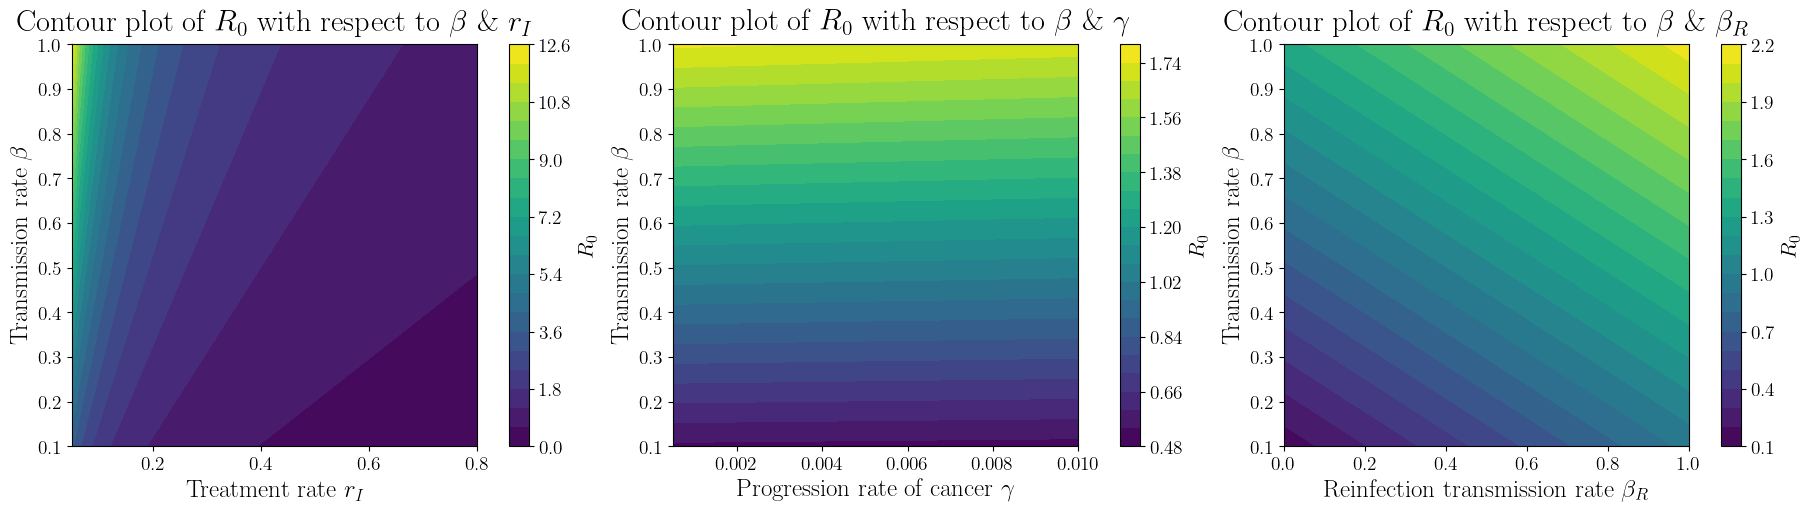

In [20]:
# ───────────────────────────────────────────────────────────────────────
# Pair-wise contour plots for R0  (β-rI, β-γ, β-βR)  
# ───────────────────────────────────────────────────────────────────────
with plt.rc_context({'axes.grid': False}):           # suppress grids only here

    # 0 ▸ Parameter grids
    n           = 60
    beta_vals   = np.linspace(0.1   , 1.0 , n)       # β
    rI_vals     = np.linspace(0.05  , 0.8 , n)       # r_I
    gamma_vals  = np.linspace(0.0005, 0.01, n)       # γ
    betaR_vals  = np.linspace(0.0   , 1.0 , n)       # β_R

    # 1 ▸ Compute R0 on the three pair-wise grids ------------------------------
    B , R   = np.meshgrid(beta_vals , rI_vals  , indexing='ij')
    R0_grid_br = R0_new(B , βR0, γ0, R , μ0)         # β vs r_I

    B , G   = np.meshgrid(beta_vals , gamma_vals, indexing='ij')
    R0_grid_bg = R0_new(B , βR0, G , rI0, μ0)        # β vs γ

    B , BR  = np.meshgrid(beta_vals , betaR_vals, indexing='ij')
    R0_grid_bbR = R0_new(B , BR , γ0, rI0, μ0)       # β vs β_R

    # 2 ▸ Helper for consistent styling ----------------------------------------
    def contour(ax, X, Y, Z, clabel,
                xlabel, ylabel, title):
        cs = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
        cbar = plt.colorbar(cs, ax=ax)
        cbar.set_label(clabel, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=18)
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_title(title, fontsize=22, pad=10)
        ax.tick_params(labelsize=14)
        ax.grid(False)                               # extra safety

    # 3 ▸ Build the 3-panel figure --------------------------------------------
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    contour(axs[0], rI_vals,  beta_vals,  R0_grid_br,
            r'$R_0$', r'Treatment rate $r_I$', r'Transmission rate $\beta$',
            r'Contour plot of $R_0$ with respect to $\beta$ \& $r_I$')

    contour(axs[1], gamma_vals, beta_vals, R0_grid_bg,
            r'$R_0$', r'Progression rate of cancer $\gamma$', r'Transmission rate $\beta$',
            r'Contour plot of $R_0$ with respect to $\beta$ \& $\gamma$')

    contour(axs[2], betaR_vals, beta_vals, R0_grid_bbR,
            r'$R_0$', r'Reinfection transmission rate $\beta_R$', r'Transmission rate $\beta$',
            r'Contour plot of $R_0$ with respect to $\beta$ \& $\beta_R$')

    plt.savefig('R0_sensitivity_pairs.pdf', dpi=300, bbox_inches='tight')
    plt.show()

## Sensitivity Analysis of Parameters

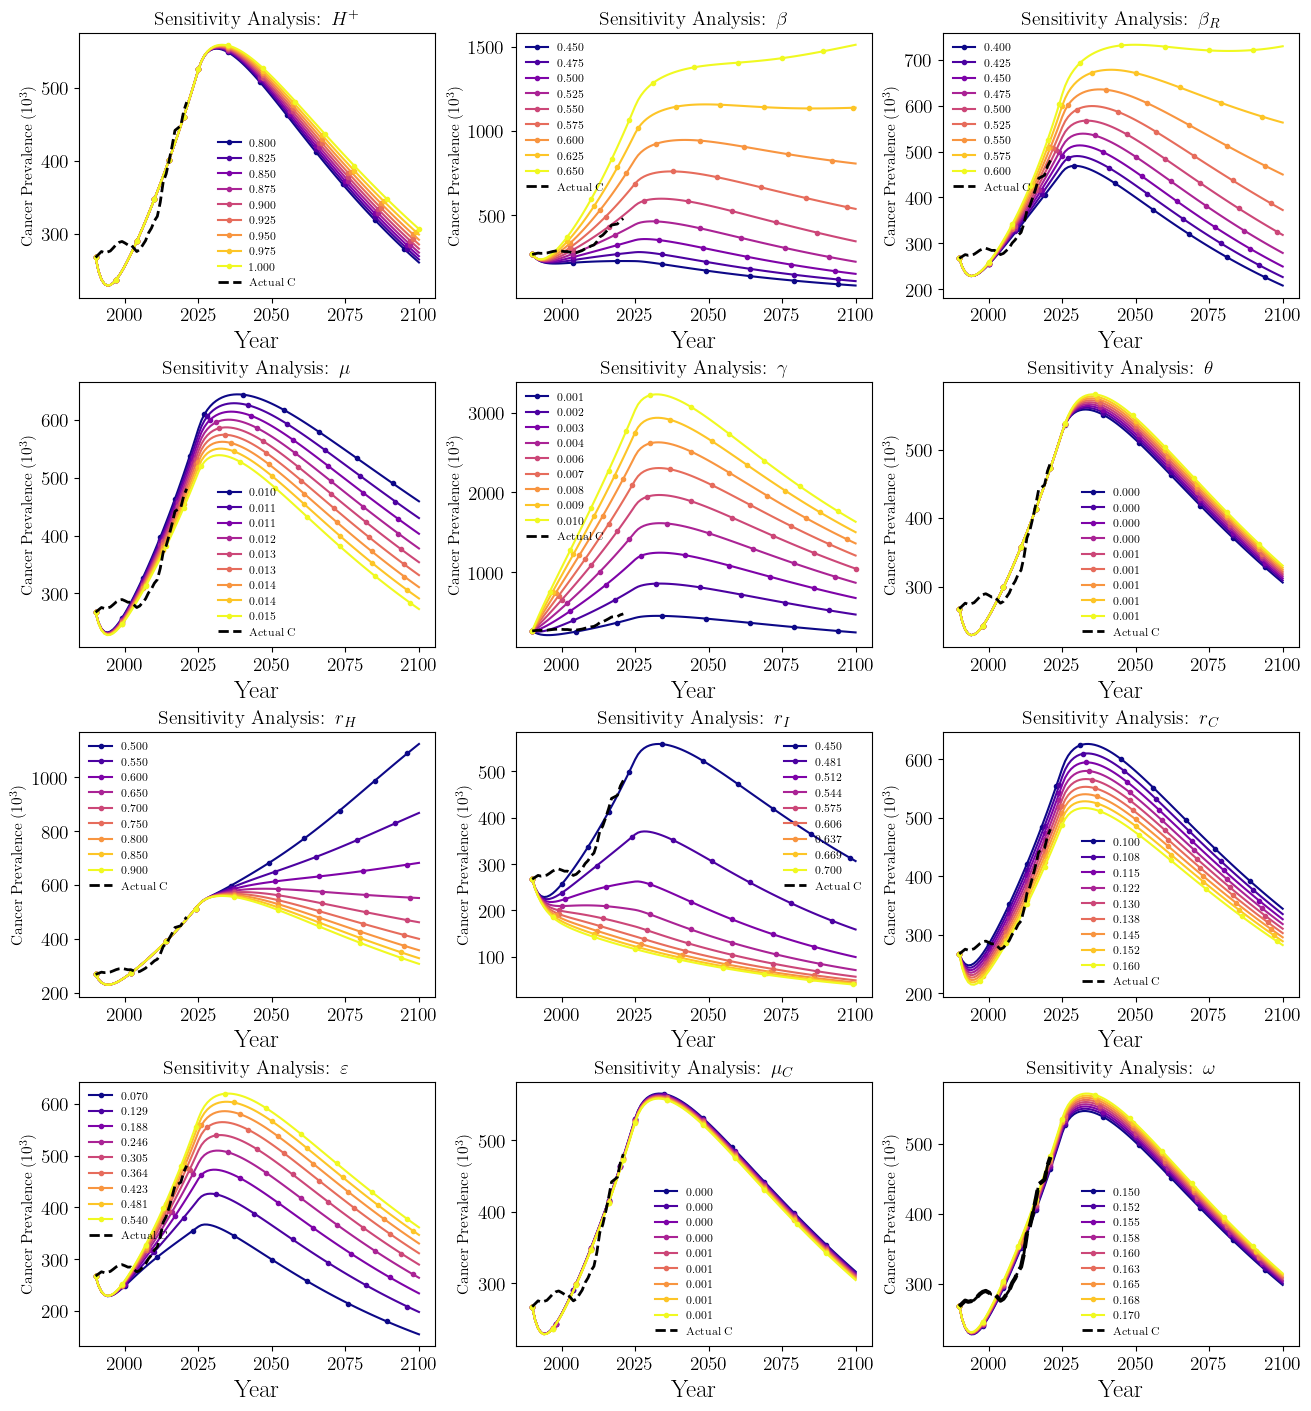

In [41]:
#   – every parameter is varied in turn while the rest stay at defaults –
#   –   cancer‐prevalence trajectory  C(t)  is used as the response     –

# ─────────────────────────── USER SETTINGS ─────────────────────────────
SIM_START_YR      = 1990      # begin integration (1990 ⇒ index-0 for obs arrays)
SIM_END_YR        = 2100
TEST_START_YR     = 2025      # year α “switches on”
ALPHA_CONST       = 0.90      # constant HPV-testing coverage after switch
AGE_LO, AGE_HI    = 30, 60    # target testing band (only needed for Λ‐tables)

# ───────────────────────── PARAMETER DEFAULTS ──────────────────────────
# (replace any ‘dummy’ value by a literature range later)
par_default = dict(
    H_pos  = 1.00,
    beta   = 0.543262,
    beta_R = 0.4932,
    mu     = 0.01388,
    gamma  = 0.00128338,
    theta  = 0.00128338/10,
    r_H    = 0.90,
    r_I    = 0.45,
    r_C    = 0.67/5,
    epsilon= 0.35,
    mu_C   = 0.000852595,
    omega  = 0.16            
)

param_ranges = {
    'H_pos' : np.linspace(0.80, 1.00, 9),
    'beta'  : np.linspace(0.45, 0.65, 9),
    'beta_R': np.linspace(0.40, 0.60, 9),
    'mu'    : np.linspace(0.010, 0.015, 9),
    'gamma' : np.linspace(0.0010, 0.010, 9),
    'theta' : np.linspace(0.0010/10,  0.010/10, 9),
    'r_H'   : np.linspace(0.5,  0.9,  9),
    'r_I'   : np.linspace(0.45,  0.70,  9),
    'r_C'   : np.linspace(0.50/5, 0.80/5, 9),
    'epsilon':np.linspace(0.07, 0.54, 9),
    'mu_C'  : np.linspace( 0.00010,  0.0010, 9),
    'omega' : np.linspace(0.15, 0.17, 9)
}

# par = dict(
#     H_pos  = 1.0,
#     beta   = 0.543262,
#     beta_R = 0.4932,
#     mu     = 0.01388,
#     gamma  = 0.00128338,
#     theta  = 0.00128338/10,
#     r_H    = 0.90,
#     r_I    = 0.45,
#     r_C    = 0.67/5,
#     epsilon= 0.35,
#     mu_C   = 0.000852595,
#     omega  = 0.16
# )

# 95 % / expert ranges for one–at–a-time sweeps  ──> edit as needed


# ───────────────────────── AGE SPLIT – CONSTANTS ───────────────────────
ages = np.arange(TOTAL_LO, TOTAL_HI+1)
idx_tgt = [a for a in ages if AGE_LO <= a <= AGE_HI]
idx_rst = [a for a in ages if a not in idx_tgt]

pop_T = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt])
         for yr,r in df_pop.set_index("Time").iterrows()}
pop_R = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst])
         for yr,r in df_pop.set_index("Time").iterrows()}

lam_T = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt])
         for yr,r in df_λ.set_index("Time").iterrows()}
lam_R = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst])
         for yr,r in df_λ.set_index("Time").iterrows()}
λ_min, λ_max = df_λ["Time"].min(), df_λ["Time"].max()
Λ_T = lambda τ: lam_T[int(np.clip(np.floor(τ), λ_min, λ_max))]
Λ_R = lambda τ: lam_R[int(np.clip(np.floor(τ), λ_min, λ_max))]

p_arr, P_arr = df_p["p"].values, df_p["P"].values
p_T, p_R     = p_arr[idx_tgt].sum(), p_arr[idx_rst].sum()
P_T, P_R     = P_arr[idx_tgt].sum(), P_arr[idx_rst].sum()

# ───────────────────────── TIME GRID & INITIALS ────────────────────────
t = np.arange(SIM_START_YR, SIM_END_YR+1)                   # yearly
idx0 = max(0, SIM_START_YR - years[0])
y0   = [ pop_T[SIM_START_YR], pop_R[SIM_START_YR], 0, 0,
         I_obs[idx0], C_obs[idx0], 0, 0, CD_obs[idx0] ]

α = lambda τ: 0.0 if τ < TEST_START_YR else ALPHA_CONST     # constant control

# ───────────────────────── MODEL RHS (HPV testing) ─────────────────────
def rhs(state, τ, p):
    S_T,S_Rest,S_R,H_T,I,C,R_H,C_S,C_D = state
    N = S_T+S_Rest+S_R+H_T+I+C+R_H+C_S+C_D
    λ_T = p['beta']   * (I+H_T)/N
    λ_R = p['beta_R'] * (I+H_T)/N
    a   = α(τ)

    dS_T   = Λ_T(τ)*p_T - ((a*p['H_pos']+1-a)*λ_T + P_T) * S_T
    dS_Rst = Λ_R(τ)*p_R - (λ_T + P_R) * S_Rest
    dS_R   = p['epsilon']*R_H - (λ_R + p['mu']) * S_R
    infl_HT= a*p['H_pos']*λ_T*S_T
    infl_I =(1-a)*λ_T*S_T + λ_T*S_Rest + λ_R*S_R
    dH_T = infl_HT - (p['theta']+p['r_H']+p['mu'])*H_T
    dI   = infl_I  - (p['gamma']+p['r_I']+p['mu'])*I
    dC   = p['theta']*H_T + p['gamma']*I + p['omega']*C_S - (p['r_C']+p['mu']+p['mu_C'])*C
    dR_H = p['r_H']*H_T + p['r_I']*I - (p['epsilon']+p['mu'])*R_H
    dC_S = p['r_C']*C - (p['omega']+p['mu'])*C_S
    dC_D = p['mu_C']*C
    return [dS_T,dS_Rst,dS_R,dH_T,dI,dC,dR_H,dC_S,dC_D]

# ───────────────────────── SOLVER ───────────────────────────────────────
def solve(par):
    return odeint(rhs, y0, t, args=(par,))

# ───────────────────────── SENSITIVITY LOOP ────────────────────────────
results = {}                             # results[param][i] gives C(t) curve
for name, sweep in param_ranges.items():
    curves = []
    for val in sweep:
        p  = par_default.copy()
        p[name] = float(val)
        curves.append( solve(p)[:,5] )   # 5 → C compartment
    results[name] = curves

# ───────────────────────── PLOTTING ────────────────────────────────────
latex = {
    'H_pos': r'$H^{+}$', 'beta':r'$\beta$', 'beta_R':r'$\beta_R$',
    'mu':r'$\mu$', 'gamma':r'$\gamma$', 'theta':r'$\theta$',
    'r_H':r'$r_H$', 'r_I':r'$r_I$', 'r_C':r'$r_C$',
    'epsilon':r'$\varepsilon$', 'mu_C':r'$\mu_C$', 'omega':r'$\omega$'
}

n_par = len(param_ranges)
n_cols = 3
n_rows = (n_par + n_cols - 1)//n_cols
fig,axs = plt.subplots(n_rows,n_cols,figsize=(13,n_rows*3.5),constrained_layout=True)
axs = axs.flatten()
cmap = plt.cm.plasma

for i,(name,sweep) in enumerate(param_ranges.items()):
    colours = cmap(np.linspace(0,1,len(sweep)))
    for curve,val,col in zip(results[name],sweep,colours):
        axs[i].plot(t, curve,
    color=col,
    linestyle='-',
    linewidth=1.5,           # <-- set desired line thickness
    marker='o',
    markersize=3,          # <-- set marker size (replace ms=2)
    label=f'{val:.3f}'
)
#         axs[i].plot(t, curve, color=col, linestyle='-', marker='o', ms=2,
#                     label=f'{val:.3f}')
    # actual data (truncate if shorter)
    axs[i].plot(t[:len(C_obs)], C_obs, 'k--', lw=2, label='Actual C')
    axs[i].set_title(f'Sensitivity Analysis: {latex.get(name,name)}',fontsize=14,fontweight='bold')
    axs[i].set_xlabel('Year',fontweight='bold')
    axs[i].set_ylabel('Cancer Prevalence  ($10^{3}$)',fontweight='bold',fontsize=11)
    axs[i].legend(fontsize=8)
    axs[i].grid()

    


axs[i].plot(t[:len(C_obs)], C_obs, 'k--', lw=3, label='Actual C')  # lw = line width


# hide empty panes
for ax in axs[n_par:]:
    ax.axis('off')

# plt.suptitle(
#     fr'One–at–a-time sensitivity  |  $\alpha$ ={ALPHA_CONST:.2f}, start={TEST_START_YR}',
#     y=1.02, fontsize=16
# )
plt.savefig('sensitivity_HPVtesting.pdf',dpi=300,bbox_inches='tight')
plt.show()

## Monte Carlo Parameter Uncertainity Analysis

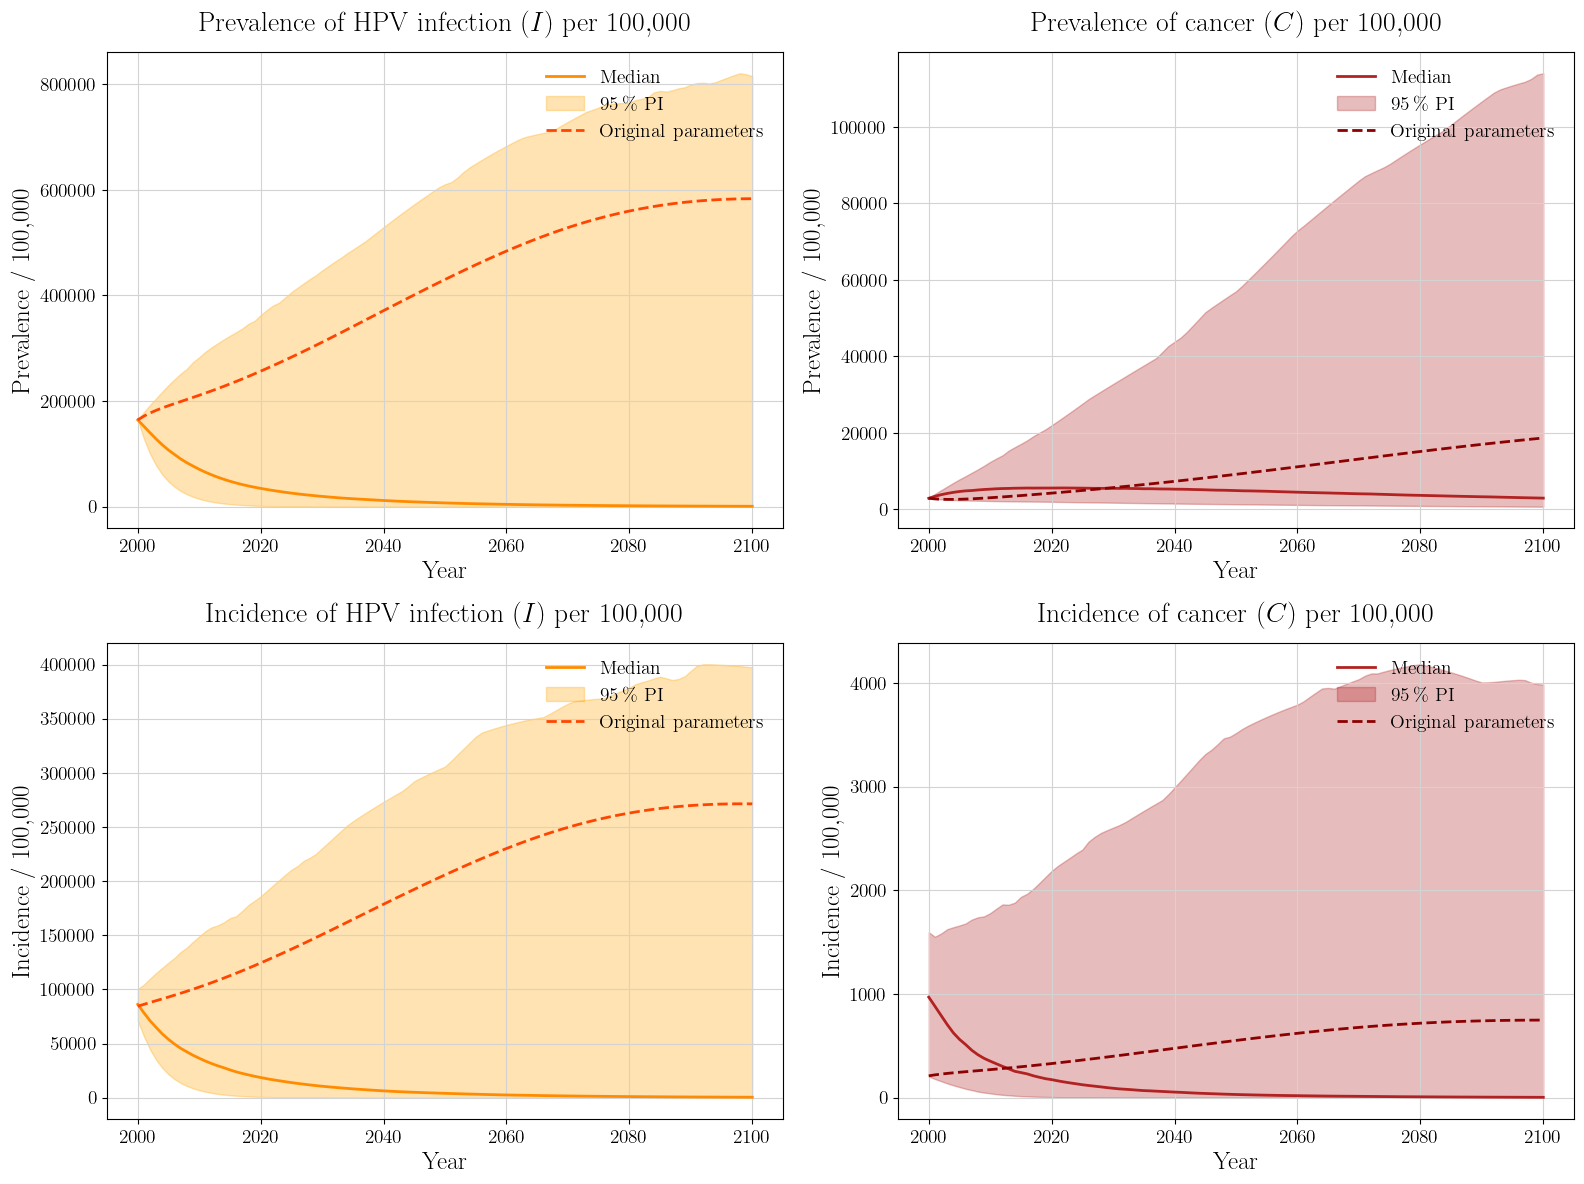


Parameter percentiles (2.5 / 50 / 97.5) + original:
H_pos   :   0.8049    0.9020    0.9953  |  orig = 1.0000
beta    :   0.4564    0.5547    0.6454  |  orig = 0.5433
beta_R  :   0.4055    0.4997    0.5954  |  orig = 0.4932
mu      :   0.0101    0.0124    0.0149  |  orig = 0.0139
gamma   :   0.0012    0.0059    0.0097  |  orig = 0.0013
theta   :   0.0001    0.0005    0.0010  |  orig = 0.0001
r_H     :   0.5091    0.7001    0.8901  |  orig = 0.9000
r_I     :   0.4568    0.5757    0.6916  |  orig = 0.4500
r_C     :   0.1015    0.1293    0.1577  |  orig = 0.1340
epsilon :   0.0876    0.3063    0.5206  |  orig = 0.3500
mu_C    :   0.0001    0.0006    0.0010  |  orig = 0.0009
omega   :   0.1505    0.1597    0.1695  |  orig = 0.1600


In [37]:
# ======================  Monte-Carlo uncertainty – HPV TESTING  ======================

# ───────────────────────────── USER KNOBS ──────────────────────────────
MC_N_SIM          = 1_000          # number of random draws
START_YEAR        = 2000
END_YEAR          = 2100
TARGET_LO, TARGET_HI = 30, 60      # testing age band
ALPHA_CONST       = 0.00           # constant testing coverage

# Parameter ranges (95 % PIs)
param_ranges = {
    'H_pos'  : (0.80, 1.0),
    'beta'   : (0.45, 0.65),
    'beta_R' : (0.40, 0.60),
    'mu'     : (0.010, 0.015),
    'gamma'  : (0.0010, 0.010),
    'theta'  : (0.0010/10, 0.010/10),
    'r_H'    : (0.50, 0.90),
    'r_I'    : (0.45, 0.70),
    'r_C'    : (0.50/5, 0.80/5),
    'epsilon': (0.07,  0.54),
    'mu_C'   : (0.00010, 0.0010),
    'omega'  : (0.15, 0.17)
}

# “Original” calibrated parameter set
par_orig = {
    'H_pos'  : 1.0,
    'beta'   : 0.543262,
    'beta_R' : 0.4932,
    'mu'     : 0.01388,
    'gamma'  : 0.00128338,
    'theta'  : 0.00128338/10,
    'r_H'    : 0.90,
    'r_I'    : 0.45,
    'r_C'    : 0.67/5,
    'epsilon': 0.35,
    'mu_C'   : 0.000852595,
    'omega'  : 0.16
}

# ───────────────────────── AGE SPLIT CONSTANTS ─────────────────────────
ages_mc = np.arange(TOTAL_LO, TOTAL_HI + 1)
idx_tgt = [a for a in ages_mc if TARGET_LO <= a <= TARGET_HI]
idx_rst = [a for a in ages_mc if a not in idx_tgt]

pop_T = {yr: sum_cols(r, [f"Age{a}" for a in idx_tgt])
         for yr, r in df_pop.set_index("Time").iterrows()}
pop_R = {yr: sum_cols(r, [f"Age{a}" for a in idx_rst])
         for yr, r in df_pop.set_index("Time").iterrows()}

lam_T = {yr: sum_cols(r, [f"Age{a}" for a in idx_tgt])
         for yr, r in df_λ.set_index("Time").iterrows()}
lam_R = {yr: sum_cols(r, [f"Age{a}" for a in idx_rst])
         for yr, r in df_λ.set_index("Time").iterrows()}
λ_min, λ_max = df_λ["Time"].min(), df_λ["Time"].max()
Λ_T = lambda τ: lam_T[int(np.clip(np.floor(τ), λ_min, λ_max))]
Λ_R = lambda τ: lam_R[int(np.clip(np.floor(τ), λ_min, λ_max))]

p_arr, P_arr = df_p["p"].values, df_p["P"].values
p_T, p_R = p_arr[idx_tgt].sum(), p_arr[idx_rst].sum()
P_T, P_R = P_arr[idx_tgt].sum(), P_arr[idx_rst].sum()

# ───────────────────────── time axis & initials ────────────────────────
t = np.arange(START_YEAR, END_YEAR + 1)
idx0 = max(0, START_YEAR - years[0])
y0 = [pop_T[START_YEAR], pop_R[START_YEAR], 0.0, 0.0,
      I_obs[idx0], C_obs[idx0], 0.0, 0.0, CD_obs[idx0]]

α_profile = lambda τ: 0.0 if τ < START_YEAR else ALPHA_CONST

# ───────────────────── RHS of HPV-Testing model (same as earlier) ──────
def rhs(state, τ, p):
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = state
    N = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T = p['beta']   * (I + H_T) / N
    λ_R = p['beta_R'] * (I + H_T) / N
    a   = α_profile(τ)

    dS_T   = Λ_T(τ)*p_T - ((a*p['H_pos'] + 1 - a) * λ_T + P_T) * S_T
    dS_Rst = Λ_R(τ)*p_R - (λ_T + P_R) * S_Rest
    dS_R   = p['epsilon'] * R_H - (λ_R + p['mu']) * S_R
    infl_HT = a * p['H_pos'] * λ_T * S_T
    infl_I  = (1 - a) * λ_T * S_T + λ_T * S_Rest + λ_R * S_R
    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu']) * H_T
    dI   = infl_I   - (p['gamma'] + p['r_I'] + p['mu']) * I
    dC   = p['theta'] * H_T + p['gamma'] * I + p['omega'] * C_S \
           - (p['r_C'] + p['mu'] + p['mu_C']) * C
    dR_H = p['r_H'] * H_T + p['r_I'] * I - (p['epsilon'] + p['mu']) * R_H
    dC_S = p['r_C'] * C - (p['omega'] + p['mu']) * C_S
    dC_D = p['mu_C'] * C
    return [dS_T, dS_Rst, dS_R, dH_T, dI, dC, dR_H, dC_S, dC_D]

# ───────────────────────── Monte-Carlo storage ─────────────────────────
prev_I  = np.zeros((MC_N_SIM, len(t)))
prev_C  = np.zeros((MC_N_SIM, len(t)))
inc_I   = np.zeros_like(prev_I)
inc_C   = np.zeros_like(prev_C)
samples = {k: [] for k in param_ranges}

# ───────────────────────── Monte-Carlo loop ────────────────────────────
for k in range(MC_N_SIM):
    p = {key: np.random.uniform(lo, hi) for key, (lo, hi) in param_ranges.items()}
    for key in p:
        samples[key].append(p[key])

    sol = odeint(rhs, y0, t, args=(p,))
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = sol.T
    N = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T_all = p['beta']   * (I + H_T) / N
    λ_R_all = p['beta_R'] * (I + H_T) / N

    # prevalence
    prev_I[k] = I * 10
    prev_C[k] = C * 10

    # incidence
    inc_I[k] = ((1 - ALPHA_CONST) * λ_T_all * S_T +
                λ_T_all * S_Rest + λ_R_all * S_R) * 10
    inc_C[k] = (p['theta'] * H_T + p['gamma'] * I) * 10

# ───────────────────────── original run ────────────────────────────────
sol0 = odeint(rhs, y0, t, args=(par_orig,))
I0, C0 = sol0[:, 4], sol0[:, 5]
prev_I0 = I0 * 10
prev_C0 = C0 * 10
λ_T0 = par_orig['beta']   * (I0 + sol0[:, 3]) / sol0.sum(1)
λ_R0 = par_orig['beta_R'] * (I0 + sol0[:, 3]) / sol0.sum(1)
inc_I0 = ((1 - ALPHA_CONST) * λ_T0 * sol0[:, 0] +
          λ_T0 * sol0[:, 1] + λ_R0 * sol0[:, 2]) * 10
inc_C0 = (par_orig['theta'] * sol0[:, 3] + par_orig['gamma'] * I0) * 10

# ───────────────────────── percentiles ─────────────────────────────────
pct = lambda arr: (np.percentile(arr, 2.5, 0),
                   np.percentile(arr, 50, 0),
                   np.percentile(arr, 97.5, 0))
prevI_lo, prevI_med, prevI_hi = pct(prev_I)
prevC_lo, prevC_med, prevC_hi = pct(prev_C)
incI_lo, incI_med, incI_hi = pct(inc_I)
incC_lo, incC_med, incC_hi = pct(inc_C)

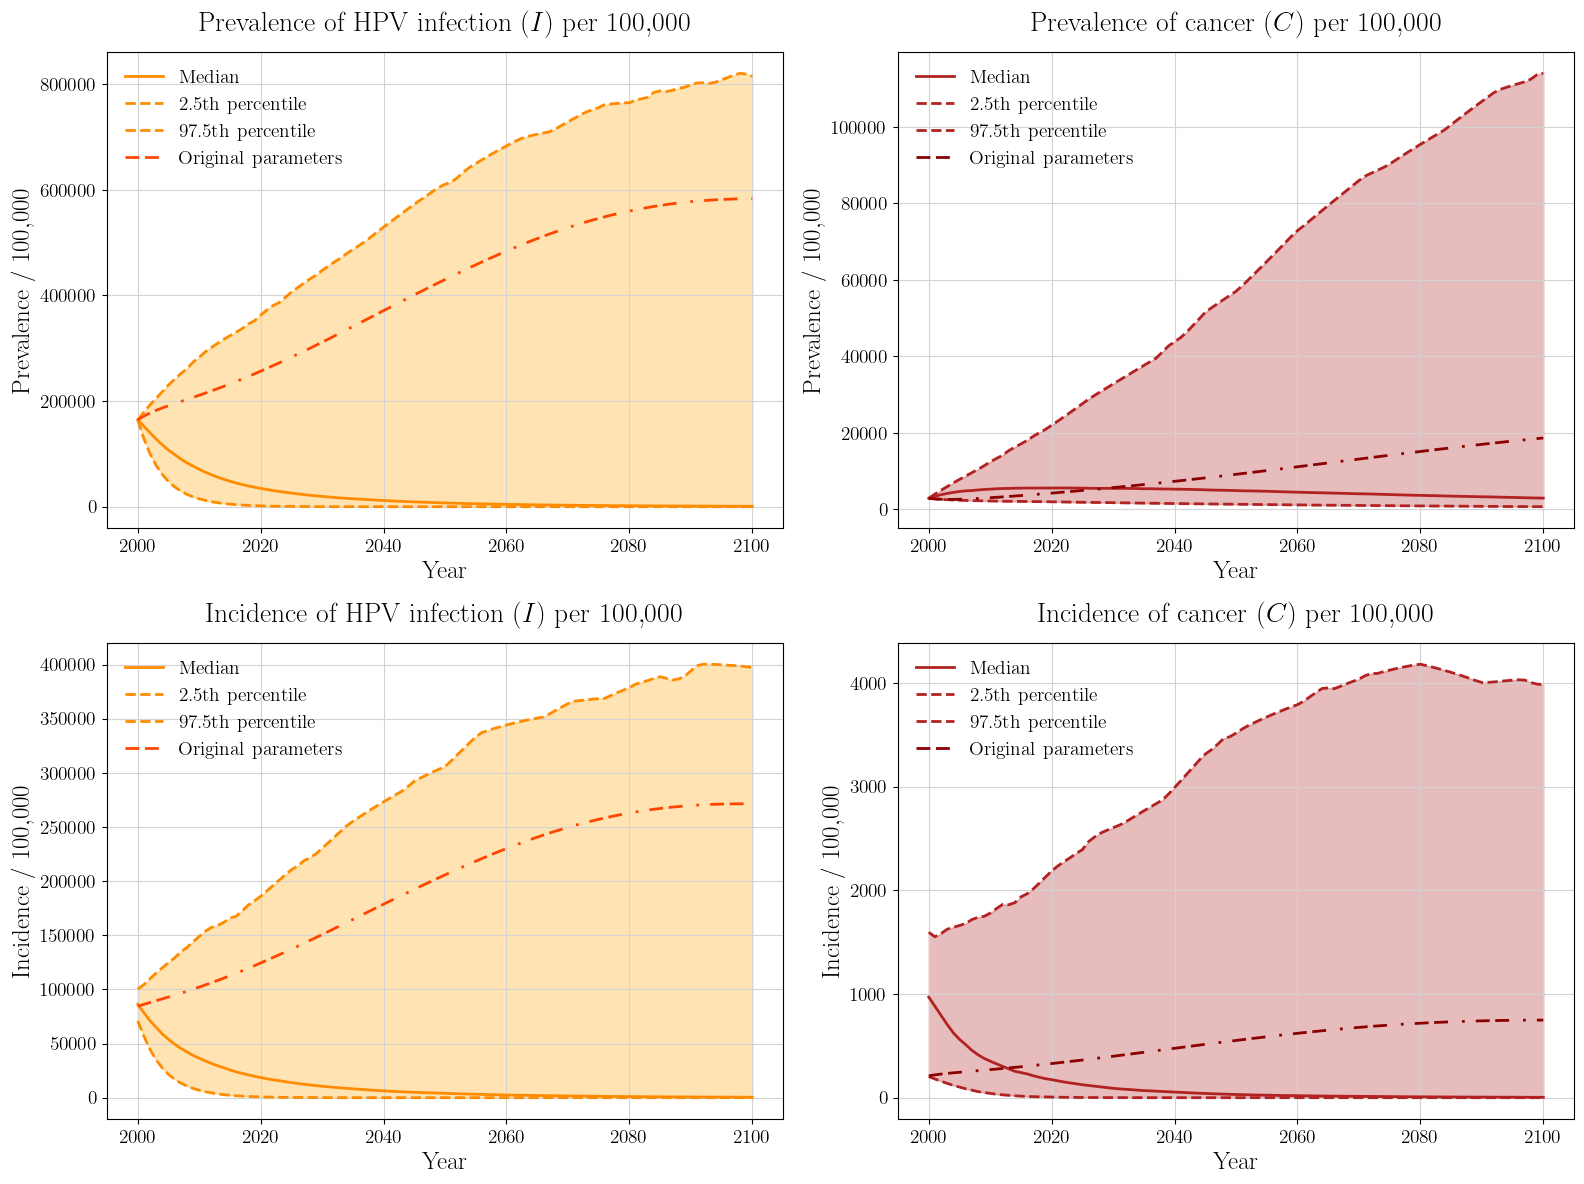

In [38]:
# ───────────────────────── plotting – same style as screening model ────
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Common helpers
def add_ci(ax, years, median, lo, hi, col_main, col_fill, label_med, label_lo, label_hi):
    """Draw median + dashed 2.5 / 97.5 % lines and shaded band."""
    ax.plot(years, median, color=col_main, lw=2, label=label_med)
    ax.plot(years, lo,      color=col_main, lw=2, ls='--', label=label_lo)
    ax.plot(years, hi,      color=col_main, lw=2, ls='--', label=label_hi)
    ax.fill_between(years, lo, hi, color=col_fill, alpha=0.3)

# Prevalence I
add_ci(axs[0, 0], t, prevI_med, prevI_lo, prevI_hi,
       'darkorange', 'orange',
       'Median', '2.5th percentile', '97.5th percentile')
axs[0, 0].plot(t, prev_I0, color='orangered', lw=2,
               label='Original parameters')
axs[0, 0].set_title('Prevalence of HPV infection ($I$) per $100{,}000$', pad=15)
axs[0, 0].set_xlabel('Year'); axs[0, 0].set_ylabel('Prevalence / $100{,}000$')
axs[0, 0].legend(); axs[0, 0].grid(True)

# Prevalence C
add_ci(axs[0, 1], t, prevC_med, prevC_lo, prevC_hi,
       'firebrick', 'firebrick',
       'Median', '2.5th percentile', '97.5th percentile')
axs[0, 1].plot(t, prev_C0, color='darkred', lw=2,
               label='Original parameters')
axs[0, 1].set_title('Prevalence of cancer ($C$) per $100{,}000$', pad=15)
axs[0, 1].set_xlabel('Year'); axs[0, 1].set_ylabel('Prevalence / $100{,}000$')
axs[0, 1].legend(); axs[0, 1].grid(True)

# Incidence I
add_ci(axs[1, 0], t, incI_med, incI_lo, incI_hi,
       'darkorange', 'orange',
       'Median', '2.5th percentile', '97.5th percentile')
axs[1, 0].plot(t, inc_I0, color='orangered', lw=2,
               label='Original parameters')
axs[1, 0].set_title('Incidence of HPV infection ($I$) per $100{,}000$', pad=15)
axs[1, 0].set_xlabel('Year'); axs[1, 0].set_ylabel('Incidence / $100{,}000$')
axs[1, 0].legend(); axs[1, 0].grid(True)

# Incidence C
add_ci(axs[1, 1], t, incC_med, incC_lo, incC_hi,
       'firebrick', 'firebrick',
       'Median', '2.5th percentile', '97.5th percentile')
axs[1, 1].plot(t, inc_C0, color='darkred', lw=2,
               label='Original parameters')
axs[1, 1].set_title('Incidence of cancer ($C$) per $100{,}000$', pad=15)
axs[1, 1].set_xlabel('Year'); axs[1, 1].set_ylabel('Incidence / $100{,}000$')
axs[1, 1].legend(); axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('MC_uncertainty_HPVtesting.pdf', format='pdf',
            dpi=300, bbox_inches='tight')
plt.show()

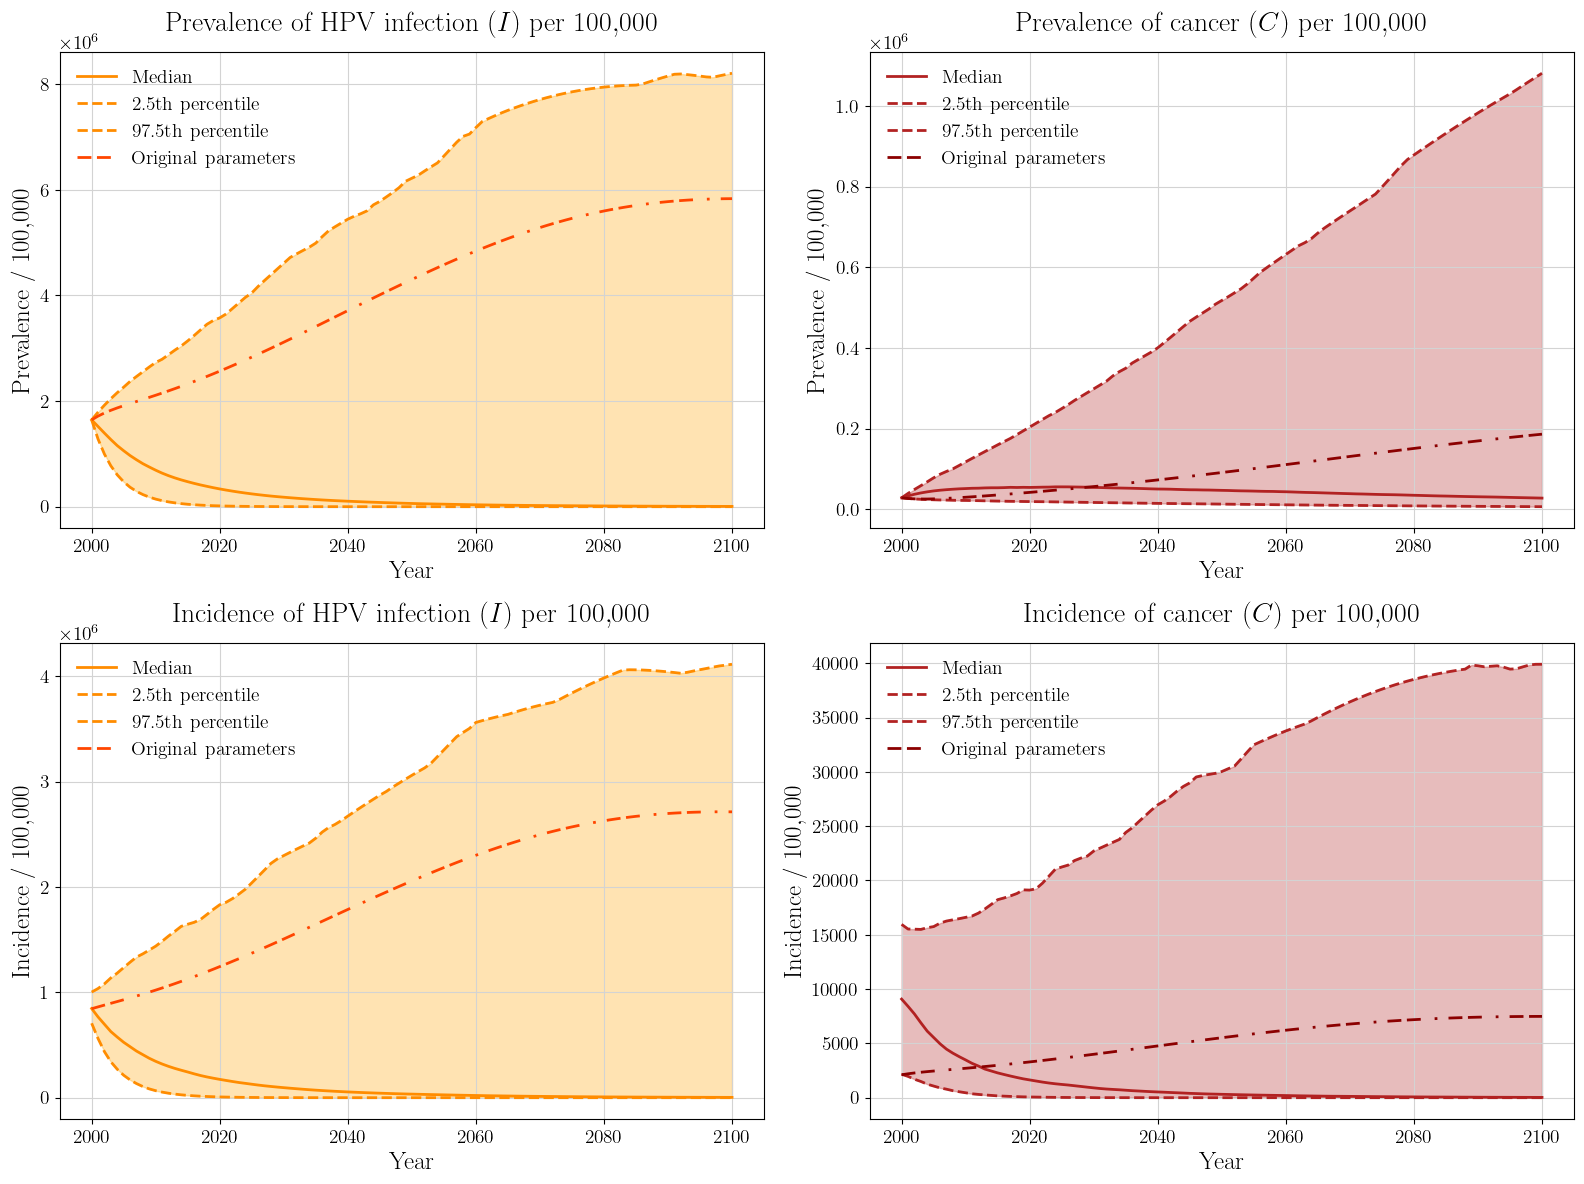


Parameter percentiles (2.5 / 50 / 97.5) + original:
H_pos   :   0.8039    0.9036    0.9945  |  orig = 1.0000
beta    :   0.4545    0.5446    0.6448  |  orig = 0.5433
beta_R  :   0.4045    0.5072    0.5956  |  orig = 0.4932
mu      :   0.0102    0.0127    0.0149  |  orig = 0.0139
gamma   :   0.0013    0.0055    0.0097  |  orig = 0.0013
theta   :   0.0001    0.0006    0.0010  |  orig = 0.0001
r_H     :   0.5099    0.6997    0.8899  |  orig = 0.9000
r_I     :   0.4555    0.5728    0.6938  |  orig = 0.4500
r_C     :   0.1009    0.1296    0.1584  |  orig = 0.1340
epsilon :   0.0824    0.2971    0.5300  |  orig = 0.3500
mu_C    :   0.0001    0.0005    0.0010  |  orig = 0.0009
omega   :   0.1504    0.1595    0.1694  |  orig = 0.1600


In [39]:
# ======================  Monte-Carlo uncertainty – HPV TESTING  ======================

# ───────────────────────── USER-CONFIGURABLE PART (unchanged) ────────────────────────
MC_N_SIM   = 1_000
START_YEAR = 2000
END_YEAR   = 2100
TARGET_LO, TARGET_HI = 30, 60
ALPHA_CONST = 0.00          # constant testing coverage
SCALE = 100                 # <-- compartments are in *thousands*

# … (param_ranges, par_orig, demographic setup – leave exactly as in your cell) …

# ───────────────────────── time axis & initial state  ────────────────────────────────
t = np.arange(START_YEAR, END_YEAR + 1)
idx0 = max(0, START_YEAR - years[0])
y0 = [pop_T[START_YEAR], pop_R[START_YEAR], 0.0, 0.0,
      I_obs[idx0], C_obs[idx0], 0.0, 0.0, CD_obs[idx0]]

α_profile = lambda τ: 0.0 if τ < START_YEAR else ALPHA_CONST

# ───────────────────────── RHS of HPV-testing model  ────────────────────────────────
def rhs(state, τ, p):
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = state
    N = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T = p['beta']   * (I + H_T) / N
    λ_R = p['beta_R'] * (I + H_T) / N
    a   = α_profile(τ)

    dS_T   = Λ_T(τ)*p_T - ((a*p['H_pos'] + 1 - a) * λ_T + P_T) * S_T
    dS_Rst = Λ_R(τ)*p_R - (λ_T + P_R) * S_Rest
    dS_R   = p['epsilon'] * R_H - (λ_R + p['mu']) * S_R

    infl_HT = a * p['H_pos'] * λ_T * S_T          # not used again, but kept for clarity
    infl_I  = (1 - a) * λ_T * S_T + λ_T * S_Rest + λ_R * S_R

    dH_T = infl_HT - (p['theta'] + p['r_H'] + p['mu']) * H_T
    dI   = infl_I   - (p['gamma'] + p['r_I'] + p['mu']) * I
    dC   = p['theta'] * H_T + p['gamma'] * I + p['omega'] * C_S \
           - (p['r_C'] + p['mu'] + p['mu_C']) * C
    dR_H = p['r_H'] * H_T + p['r_I'] * I - (p['epsilon'] + p['mu']) * R_H
    dC_S = p['r_C'] * C - (p['omega'] + p['mu']) * C_S
    dC_D = p['mu_C'] * C
    return [dS_T, dS_Rst, dS_R, dH_T, dI, dC, dR_H, dC_S, dC_D]

# ───────────────────────── Monte-Carlo storage  ─────────────────────────────────────
prev_I = np.zeros((MC_N_SIM, len(t)))
prev_C = np.zeros_like(prev_I)
inc_I  = np.zeros_like(prev_I)
inc_C  = np.zeros_like(prev_I)
samples = {k: [] for k in param_ranges}

# ───────────────────────── Monte-Carlo loop  ────────────────────────────────────────
for k in range(MC_N_SIM):
    p = {k: np.random.uniform(lo, hi) for k, (lo, hi) in param_ranges.items()}
    for key in p: samples[key].append(p[key])

    sol = odeint(rhs, y0, t, args=(p,))
    S_T, S_Rest, S_R, H_T, I, C, R_H, C_S, C_D = sol.T
    N = S_T + S_Rest + S_R + H_T + I + C + R_H + C_S + C_D
    λ_T_all = p['beta']   * (I + H_T) / N
    λ_R_all = p['beta_R'] * (I + H_T) / N

    # prevalence per 100 000
    prev_I[k] = I * SCALE
    prev_C[k] = C * SCALE

    # incidence per 100 000
    infl_I = (1 - ALPHA_CONST) * λ_T_all * S_T + λ_T_all * S_Rest + λ_R_all * S_R
    infl_C = p['theta'] * H_T + p['gamma'] * I
    inc_I[k] = infl_I * SCALE
    inc_C[k] = infl_C * SCALE

# ───────────────────────── original-parameter trajectory  ───────────────────────────
sol0 = odeint(rhs, y0, t, args=(par_orig,))
I0, C0 = sol0[:, 4], sol0[:, 5]
prev_I0 = I0 * SCALE
prev_C0 = C0 * SCALE
λ_T0 = par_orig['beta']   * (I0 + sol0[:, 3]) / sol0.sum(1)
λ_R0 = par_orig['beta_R'] * (I0 + sol0[:, 3]) / sol0.sum(1)
inc_I0 = ((1 - ALPHA_CONST) * λ_T0 * sol0[:, 0] +
          λ_T0 * sol0[:, 1] + λ_R0 * sol0[:, 2]) * SCALE
inc_C0 = (par_orig['theta'] * sol0[:, 3] + par_orig['gamma'] * I0) * SCALE

# ───────────────────────── percentiles  ─────────────────────────────────────────────
pct = lambda arr: (np.percentile(arr, 2.5, 0),
                   np.percentile(arr, 50, 0),
                   np.percentile(arr, 97.5, 0))
prevI_lo, prevI_med, prevI_hi = pct(prev_I)
prevC_lo, prevC_med, prevC_hi = pct(prev_C)
incI_lo, incI_med, incI_hi = pct(inc_I)
incC_lo, incC_med, incC_hi = pct(inc_C)

# ───────────────────────── plotting (same style as screening MC) ─────────────────────
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

def add_ci(ax, years, median, lo, hi, col_main, col_fill,
           label_med='Median', label_lo='2.5th percentile',
           label_hi='97.5th percentile'):
    ax.plot(years, median, color=col_main, lw=2, label=label_med)
    ax.plot(years, lo,  color=col_main, lw=2, ls='--', label=label_lo)
    ax.plot(years, hi,  color=col_main, lw=2, ls='--', label=label_hi)
    ax.fill_between(years, lo, hi, color=col_fill, alpha=0.3)

# Prevalence I
add_ci(axs[0, 0], t, prevI_med, prevI_lo, prevI_hi, 'darkorange', 'orange')
axs[0, 0].plot(t, prev_I0, color='orangered', lw=2, label='Original parameters')
axs[0, 0].set_title('Prevalence of HPV infection ($I$) per $100{,}000$', pad=15)
axs[0, 0].set_xlabel('Year'); axs[0, 0].set_ylabel('Prevalence / $100{,}000$')
axs[0, 0].legend(); axs[0, 0].grid(True)

# Prevalence C
add_ci(axs[0, 1], t, prevC_med, prevC_lo, prevC_hi, 'firebrick', 'firebrick')
axs[0, 1].plot(t, prev_C0, color='darkred', lw=2, label='Original parameters')
axs[0, 1].set_title('Prevalence of cancer ($C$) per $100{,}000$', pad=15)
axs[0, 1].set_xlabel('Year'); axs[0, 1].set_ylabel('Prevalence / $100{,}000$')
axs[0, 1].legend(); axs[0, 1].grid(True)

# Incidence I
add_ci(axs[1, 0], t, incI_med, incI_lo, incI_hi, 'darkorange', 'orange')
axs[1, 0].plot(t, inc_I0, color='orangered', lw=2, label='Original parameters')
axs[1, 0].set_title('Incidence of HPV infection ($I$) per $100{,}000$', pad=15)
axs[1, 0].set_xlabel('Year'); axs[1, 0].set_ylabel('Incidence / $100{,}000$')
axs[1, 0].legend(); axs[1, 0].grid(True)

# Incidence C
add_ci(axs[1, 1], t, incC_med, incC_lo, incC_hi, 'firebrick', 'firebrick')
axs[1, 1].plot(t, inc_C0, color='darkred', lw=2, label='Original parameters')
axs[1, 1].set_title('Incidence of cancer ($C$) per $100{,}000$', pad=15)
axs[1, 1].set_xlabel('Year'); axs[1, 1].set_ylabel('Incidence / $100{,}000$')
axs[1, 1].legend(); axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('MC_uncertainty_HPVtesting.pdf', format='pdf',
            dpi=300, bbox_inches='tight')
plt.show()

# ───────────────────────── parameter summary  ───────────────────────────────────────
print('\nParameter percentiles (2.5 / 50 / 97.5) + original:')
for k in param_ranges:
    lo, med, hi = np.percentile(samples[k], [2.5, 50, 97.5])
    print(f"{k:8s}: {lo:8.4f}  {med:8.4f}  {hi:8.4f}  |  orig = {par_orig.get(k, np.nan):.4f}")

## Optimal Control

$$
  J\!\bigl[\alpha(\cdot)\bigr]\;=\;
  \int_{t_0}^{t_f}
  \Bigl(
      A\,C(t) \;+\;
      B\,\alpha(t)^{p}\,S_{\text{target}}(t)
  \Bigr)\,dt
$$

Where,

$$A = \text{cost per prevalent cancer case (e.g. ₹60,000)}$$  
$$B = \text{cost weight per unit HPV–testing effort (e.g. ₹3,000)}$$  
$$p \in \{1,2,3,\dots\} = \text{COST POWER (1 = linear, 2 = quadratic …)}$$  
$$C(t) = \text{cervical‐cancer prevalence at time } t$$  
$$\alpha(t) \in [0,1] = \text{HPV testing coverage at time } t$$  
$$S_{\text{target}}(t) = \text{susceptible women in the chosen target age band}$$  

Converged after 9 sweeps.


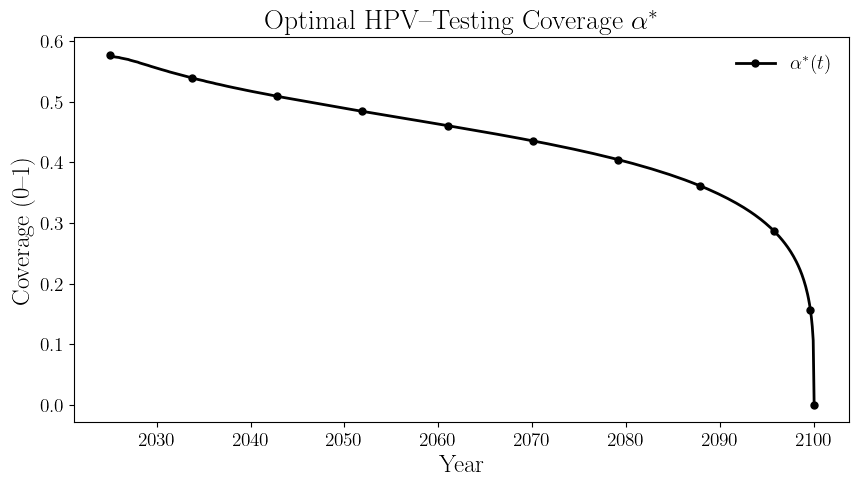

In [66]:
OPT_LO, OPT_HI   = 30, 60       # testing age band
OPT_SCR_START    = 2025         # policy starts in this calendar year
A_cost           = 60_000       # ₹ / prevalent cancer case
B_cost           = 3_000        # ₹ / unit testing effort

COST_POWER = 8          # 1 = linear, 2 = quadratic, 3/4/5 = cubic, quartic …

# ─────────────────────────────────────────────────────────────────────────
# ∇ₓ L  ——  needs no change (works for any integer p ≥ 1)
def grad_L(x, a):
    """
    gradient of the running cost w.r.t. the state vector x
      L(a,x) =  A_cost·C  +  B_cost·a^p·S_target
    """
    g = np.zeros(9)
    g[0] = B_cost * a**COST_POWER          # ∂L/∂S_target
    g[5] = A_cost                          # ∂L/∂C
    return g

# ——————————————————————  derived age tables  ——————————————————————
ages_opt = np.arange(TOTAL_LO, TOTAL_HI+1)
idx_tgt  = [a for a in ages_opt if OPT_LO <= a <= OPT_HI]
idx_rst  = [a for a in ages_opt if a not in idx_tgt]

pop_T = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt])
         for yr,r in df_pop.set_index("Time").iterrows()}
pop_R = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst])
         for yr,r in df_pop.set_index("Time").iterrows()}
lam_T = {yr: sum_cols(r,[f"Age{a}" for a in idx_tgt])
         for yr,r in df_λ.set_index("Time").iterrows()}
lam_R = {yr: sum_cols(r,[f"Age{a}" for a in idx_rst])
         for yr,r in df_λ.set_index("Time").iterrows()}
λ_min, λ_max = df_λ["Time"].min(), df_λ["Time"].max()
Λ_T = lambda τ: lam_T[int(np.clip(np.floor(τ), λ_min, λ_max))]
Λ_R = lambda τ: lam_R[int(np.clip(np.floor(τ), λ_min, λ_max))]

p_arr, P_arr  = df_p["p"].values, df_p["P"].values
p_T, p_R      = p_arr[idx_tgt].sum(), p_arr[idx_rst].sum()
P_T, P_R      = P_arr[idx_tgt].sum(), P_arr[idx_rst].sum()

S_T_obs = np.array([pop_T[yr] for yr in years])
S_R_obs = np.array([pop_R[yr] for yr in years])

# ——————————————————————  time grid  ——————————————————————
t0, tF = OPT_SCR_START, END_YEAR
t_opt  = np.linspace(t0, tF, (tF-t0)*10 + 1)   # 10 steps / yr
dt, M  = t_opt[1]-t_opt[0], len(t_opt)-1

# ——————————————————————  arrays & initials  ————————————————————
X     = np.zeros((M+1, 9))      # states
Lam   = np.zeros((M+1, 9))      # costates
alpha = np.zeros(M+1)           # control

idx0  = int(np.clip(OPT_SCR_START-START_YEAR, 0, len(I_obs)-1))
X[0]  = [S_T_obs[idx0], S_R_obs[idx0], 0, 0,
         I_obs[idx0],   C_obs[idx0],   0, 0, CD_obs[idx0]]
Lam[M] = 0                      # transversality (running-cost only)

# ——————————————————————  shorthand parameters  ——————————————————
β, βR   = par['beta'], par['beta_R']
μ       = par['mu']
γ, θ     = par['gamma'], par['theta']
rH,rI,rC= par['r_H'], par['r_I'], par['r_C']
ε, μC,ω = par['epsilon'], par['mu_C'], par['omega']
Hpos    = par['H_pos']

# ——————————————————————  state RHS  ———————————————————————
def f_state(x, a, τ):
    S_T,S_Rst,S_R,H_T,I,C,R_H,C_S,C_D = x
    N   = x.sum()
    λ_T = β  * (I+H_T)/N
    iRE = βR * (I+H_T)/N
    dST   = Λ_T(τ)*p_T - ((a*Hpos + 1-a)*λ_T + P_T) * S_T
    dSRst = Λ_R(τ)*p_R - (λ_T + P_R) * S_Rst
    dSR   = ε*R_H      - (iRE + μ) * S_R
    inflHT= a*Hpos*λ_T*S_T
    inflI = (1-a)*λ_T*S_T + λ_T*S_Rst + iRE*S_R
    dHT = inflHT - (θ + rH + μ) * H_T
    dI  = inflI  - (γ + rI + μ) * I
    dC  = θ*H_T + γ*I + ω*C_S - (rC + μ + μC) * C
    dRH = rH*H_T + rI*I       - (ε + μ) * R_H
    dCS = rC*C - (ω + μ) * C_S
    dCD = μC*C
    return np.array([dST,dSRst,dSR,dHT,dI,dC,dRH,dCS,dCD])

# ——————————————————————  Jacobian (finite-difference)  —————————
def jacobian(x,a,τ,h=1e-6):
    J = np.zeros((9,9))
    for j in range(9):
        dx = np.zeros(9); dx[j]=h
        J[:,j]=(f_state(x+dx,a,τ)-f_state(x-dx,a,τ))/(2*h)
    return J

# ——————————————————————  ∇_x L  ——————————————————————————
def grad_L(x,a):
    g = np.zeros(9)
    g[0] = B_cost * a**COST_POWER      # ∂L/∂S_T
    g[5] = A_cost                      # ∂L/∂C
    return g

# ────────────────────────────────────────────────────────────────────────
# closed-form optimal control  α★(t)   – valid for any COST_POWER ≥ 1
def alpha_star(lam, x):
    """
    Solve   (λ·∂f/∂α) + B·p·α^{p-1} = 0   for α,
    then clip the result to the admissible band   0 ≤ α ≤ 1.
    """
    S_T, _, _, H_T, I, *_ = x
    if S_T == 0:                     # avoid 0/0 divisions
        return 0.0

    # λ·∂f/∂α   — same expression you already had
    N   = x.sum()
    λ_T = β * (I + H_T) / N
    num = (lam[0]*(Hpos - 1) - lam[3]*Hpos + lam[4]) * λ_T   # scalar

    p = COST_POWER
    if p == 1:                       # linear screening cost
        alpha_opt =  np.clip(-num / (B_cost * S_T), 0.0, 1.0)

    else:                            # p ≥ 2
        rhs =  num / (B_cost * p)    # ← sign corrected here!
        alpha_opt = 0.0 if rhs <= 0 else rhs ** (1.0 / (p - 1))
        alpha_opt = np.clip(alpha_opt, 0.0, 1.0)

    return alpha_opt

# ——————————————————————  forward–backward sweep (RK-4)  ———————
MAX_IT, TOL = 80, 1e-6
for it in range(MAX_IT):

    # ---- forward (states)
    for k in range(M):
        τ,a = t_opt[k], alpha[k]
        k1 = f_state(X[k],           a, τ)
        k2 = f_state(X[k]+dt/2*k1,   a, τ+dt/2)
        k3 = f_state(X[k]+dt/2*k2,   a, τ+dt/2)
        k4 = f_state(X[k]+dt*k3,     a, τ+dt)
        X[k+1] = X[k] + dt*(k1+2*k2+2*k3+k4)/6

    # ---- backward (costates)
    for k in range(M,0,-1):
        τ,a = t_opt[k], alpha[k]
        J   = jacobian(X[k],a,τ)
        gL  = grad_L(X[k],a)
        def g(l): return -gL - J.T@l
        l1=Lam[k]; m1=g(l1)
        m2=g(l1-dt/2*m1); m3=g(l1-dt/2*m2); m4=g(l1-dt*m3)
        Lam[k-1]=Lam[k]-dt*(m1+2*m2+2*m3+m4)/6

    # ---- control update
    alpha_old = alpha.copy()
    for k in range(M+1):
        alpha[k] = alpha_star(Lam[k], X[k])
    if np.max(np.abs(alpha-alpha_old)) < TOL:
        print(f"Converged after {it+1} sweeps."); break
else:
    print("reached MAX_IT without convergence")

# ——————————————————————  no-testing trajectory  ——————————————
no_test = np.zeros_like(X); no_test[0]=X[0]
for k in range(M):
    k1=f_state(no_test[k],0,t_opt[k])
    k2=f_state(no_test[k]+dt/2*k1,0,t_opt[k]+dt/2)
    k3=f_state(no_test[k]+dt/2*k2,0,t_opt[k]+dt/2)
    k4=f_state(no_test[k]+dt*k3,  0,t_opt[k]+dt)
    no_test[k+1]=no_test[k]+dt*(k1+2*k2+2*k3+k4)/6
no_test=no_test.T

# ——————————————————————  plots  ——————————————————————————
plt.figure(figsize=(10,5))
plt.plot(t_opt, alpha, 'o-', label=r'$\alpha^{\ast}(t)$')
plt.title(r'Optimal HPV--Testing Coverage $\alpha^{\ast}$')
plt.xlabel('Year'); plt.ylabel('Coverage (0--1)')
plt.grid(); plt.legend()
plt.savefig('optimal_alpha.pdf', dpi=300); plt.show()


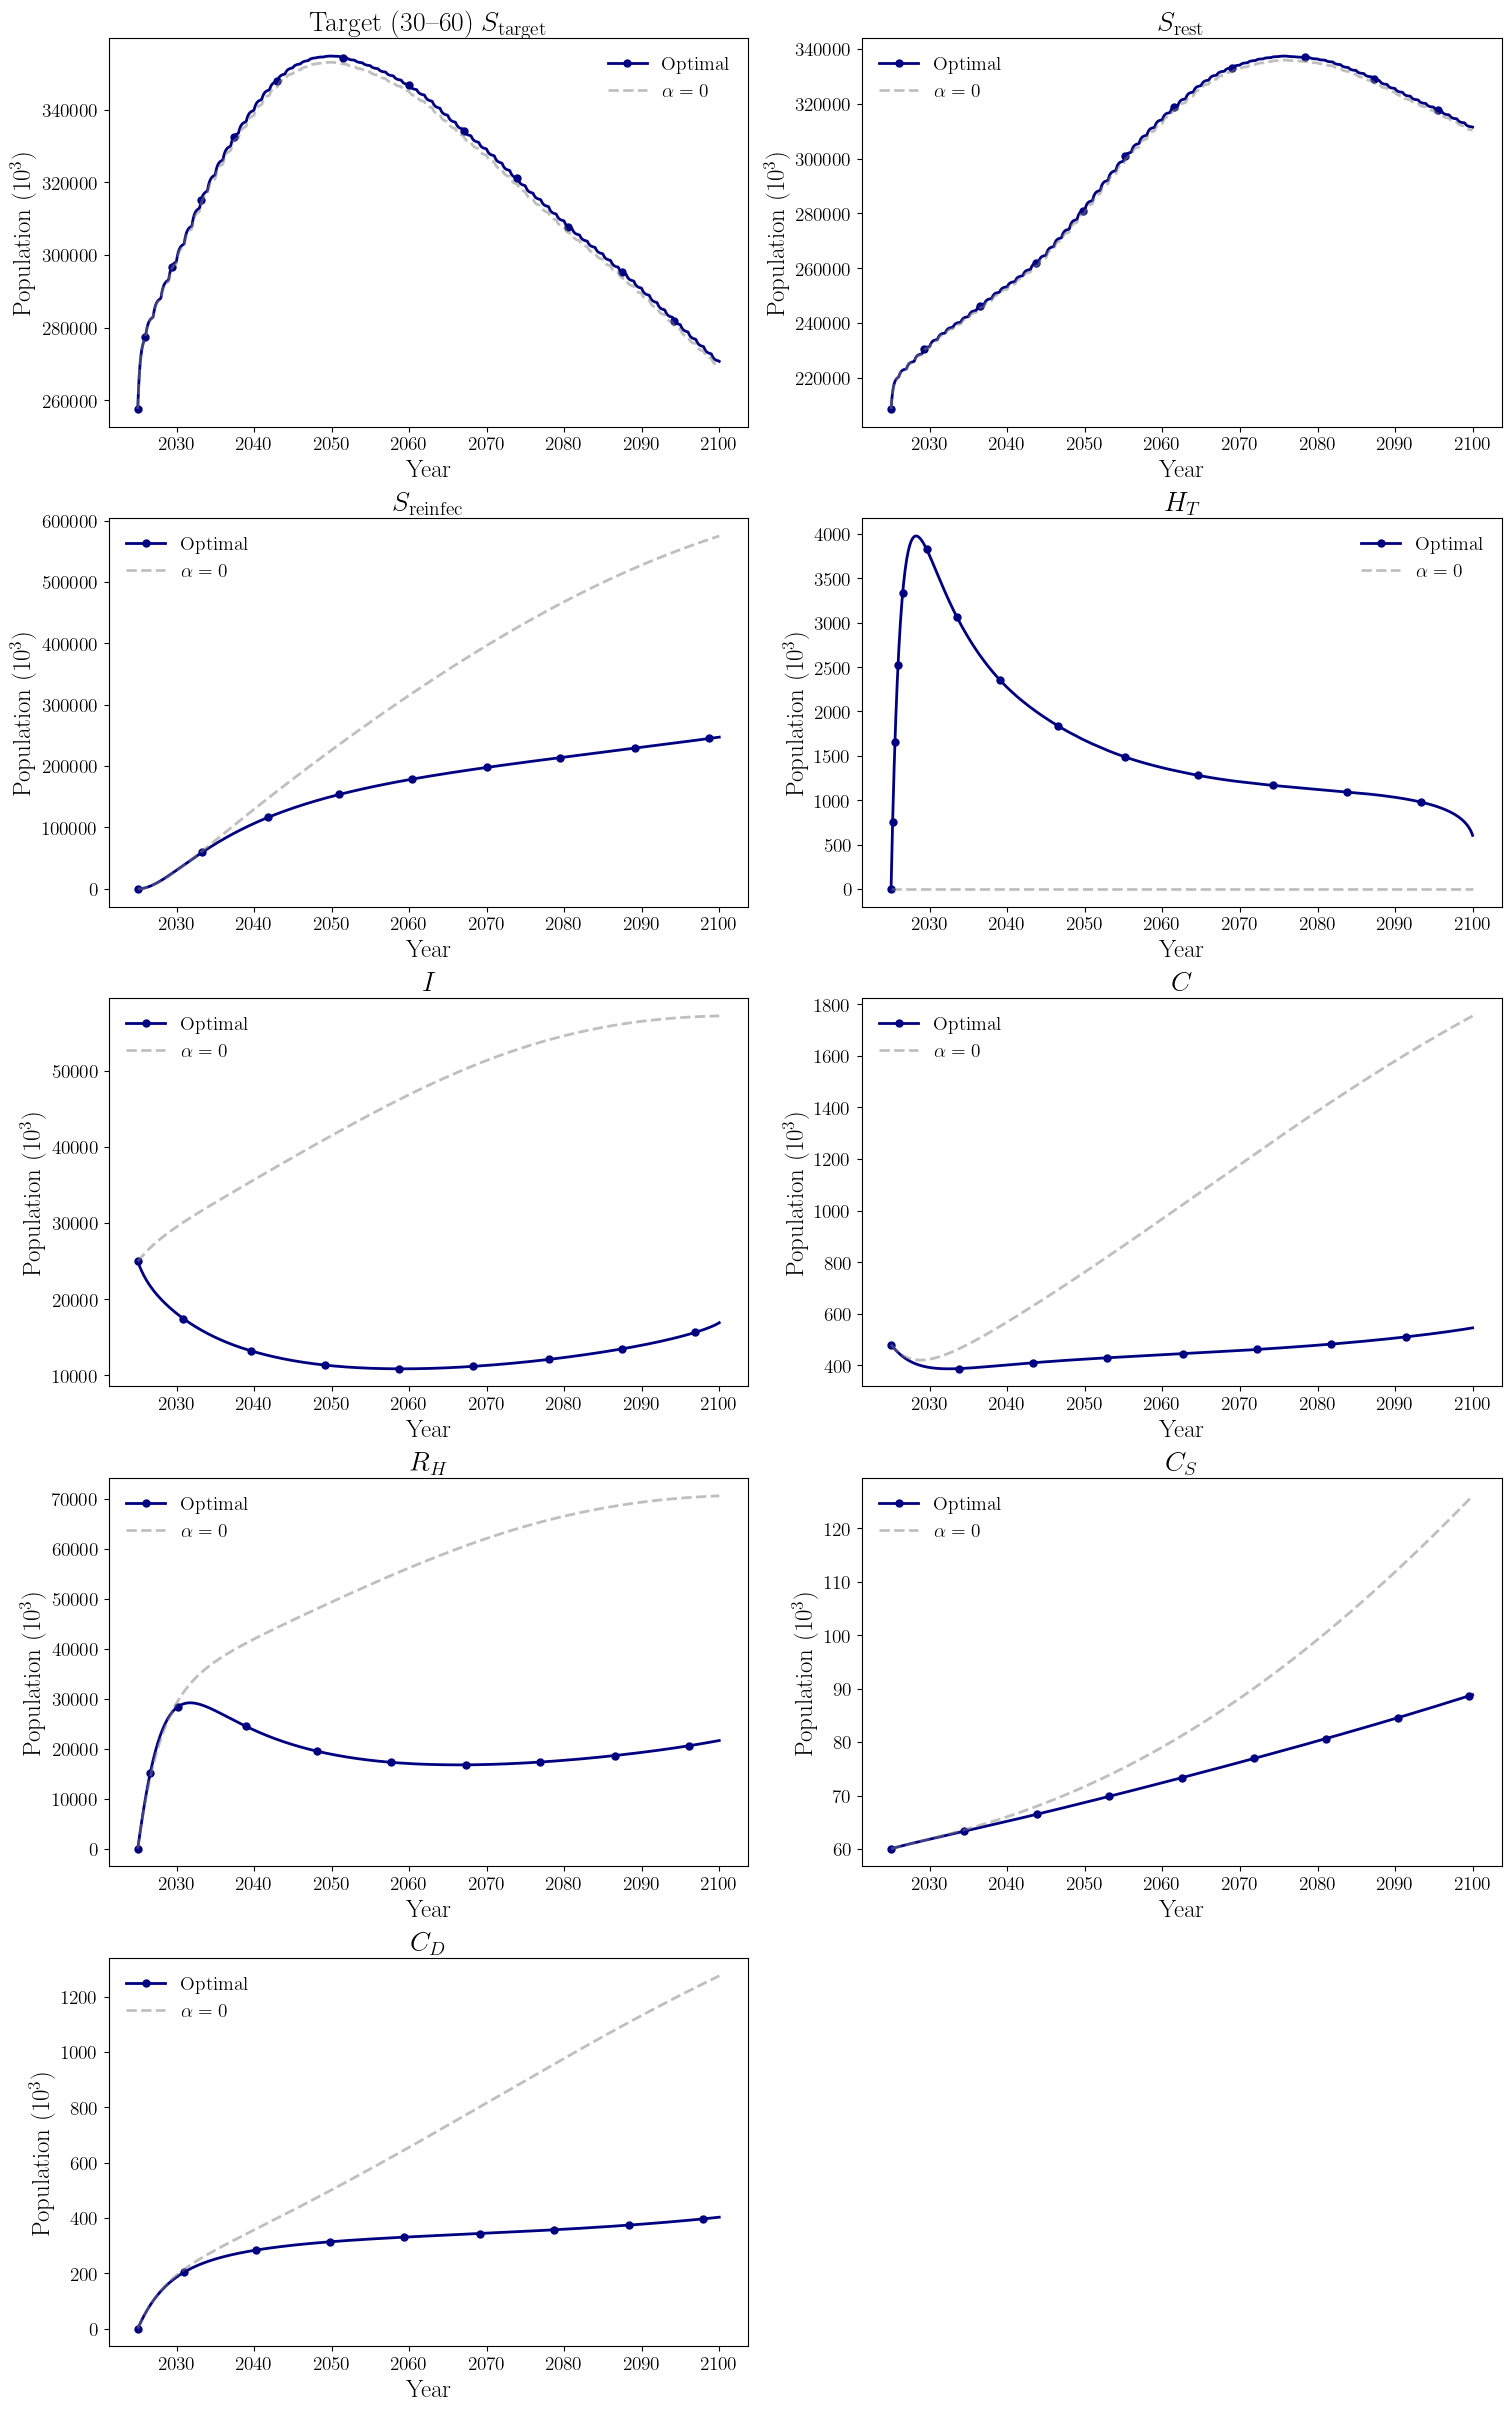

In [67]:
titles=[fr'Target ({OPT_LO}–{OPT_HI}) $S_{{\text{{target}}}}$',r'$S_{\text{rest}}$',
        r'$S_{\text{reinfec}}$',r'$H_T$',r'$I$',r'$C$',r'$R_H$',r'$C_S$',r'$C_D$']
order=[0,1,2,3,4,5,6,8,7]

fig,axs=plt.subplots(5,2,figsize=(15,24),constrained_layout=True)
axs=axs.flatten()
for i,idx in enumerate(order):
    axs[i].plot(t_opt,X[:,idx],'o-',color='navy',label='Optimal')
    axs[i].plot(t_opt,no_test[idx],'--',color='grey',alpha=.5,label=r'$\alpha=0$')
    axs[i].set_title(titles[i]); axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Population (10$^{3}$)'); axs[i].legend(); axs[i].grid()
axs[9].axis('off'); fig.savefig('opt_control_compartments.pdf',dpi=300); plt.show()